<a href="https://colab.research.google.com/github/arezoo17/AML_Detection/blob/main/AML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code was prepared by Arezoo Amani and Christian Tapia Mullo

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox
from matplotlib import dates as mdates
from scipy.stats import (ks_2samp, mannwhitneyu, shapiro, skew, stats)
from PIL import Image
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import shap




Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Load and Inspect Data

In [ ]:
file_path = "/Users/arezoo/Documents/1.MDDB/Block4/SDF/Assignment/SAML-D.csv"
df = pd.read_csv(file_path)
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


#### Feature Dictionary (Newly Created Columns)
#### This section describes the new columns extracted from the Date and Time features.
#### - `Datetime`: Combined Date and Time column in proper datetime format.
#### - `Hour`: Hour of the transaction (0-23).
#### - `DayOfWeek`: Day of the week when the transaction occurred (0=Monday, 6=Sunday).
#### - `Month`: The month in which the transaction took place (1-12).
#### - `DayOfMonth`: The specific day of the month when the transaction occurred (1-31).
#### - `IsWeekend`: A binary flag indicating if the transaction happened on a weekend:
####     - `0` = No (Transaction on a weekday: Monday-Friday)
####     - `1` = Yes (Transaction on a weekend: Saturday-Sunday)
### Payment Currency Encoding:
#### Albanian lek → 0
#### Dirham → 1
#### Euro → 2
#### Indian rupee → 3
#### Mexican Peso → 4
#### Moroccan dirham → 5
#### Naira → 6
#### Pakistani rupee → 7
#### Swiss franc → 8
#### Turkish lira → 9
#### UK pounds → 10
#### US dollar → 11
#### Yen → 12

-----

# Data Cleaning

## Dealing with Missing Values

In [ ]:
df.isnull().sum().sort_values(ascending=False)


Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64

## Removing Duplicates

In [ ]:
initial_count = df.shape[0]
df.drop_duplicates(inplace=True)
print("Dropped duplicates: ", initial_count - df.shape[0])


Dropped duplicates:  0


In [ ]:
df["Is_laundering"].value_counts()

0    9494979
1       9873
Name: Is_laundering, dtype: int64

### According to the result of this part, we can see that the data is imbalanced because the normal transactions are near to 10 million, while laundering transactions are approximately 10000.
------

## Data Type Corrections

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 942.7+ MB


----

#### In this step, we convert the `Sender_account` and `Receiver_account` columns to string type. Since they represent identifiers rather than numerical values, converting them to strings prevents misleading numerical analysis.

In [ ]:
# Convert account columns to string type
df['Sender_account'] = df['Sender_account'].astype(str)
df['Receiver_account'] = df['Receiver_account'].astype(str)

In [ ]:
# Verify the conversion by checking data types
print(df.dtypes[['Sender_account', 'Receiver_account']])

Sender_account      object
Receiver_account    object
dtype: object


In [ ]:
df.describe()

,Amount,Is_laundering
count,9.504852e+06,9.504852e+06
mean,8.762968e+03,1.038733e-03
std,2.561495e+04,3.221263e-02
min,3.730000e+00,0.000000e+00
25%,2.143688e+03,0.000000e+00
50%,6.113720e+03,0.000000e+00
75%,1.045846e+04,0.000000e+00
max,1.261850e+07,1.000000e+00


In [ ]:
# Convert account columns to integer type for the feature usage
df['Sender_account'] = df['Sender_account'].astype(int)
df['Receiver_account'] = df['Receiver_account'].astype(int)

----

# Exploratory Data Analysis (EDA)

## Univariate Analysis
**Goal:** Understand individual feature distributions.

### Visualizing the "Time" Column

We begin by examining the **Time** column, which follows the format `HH:MM:SS`. By visualizing the distribution of transactions across different hours of the day, we can identify peak transaction hours and patterns. This analysis will help us understand transaction behaviors and potentially spot time-based anomalies.

### Visualizing the Distribution of Transactions by Hour for All Transactions (`df`)

We will visualize the distribution of transactions by hour in the full dataset (`df`). This will help us understand the general pattern of transaction activity throughout the day and spot any trends or periods of peak transaction activity.

### Visualizing the Distribution of Transactions by Hour for Fraudulent Transactions (`df_Laundering`)

Next, we will examine the distribution of transactions by hour specifically for the **fraudulent transactions** in the `df_Laundering` dataset. This analysis will help us identify any unusual patterns or specific time windows when fraudulent transactions are more likely to occur.

We will:
- Extract the hour from the **Time** column in both `df` and `df_Laundering`.
- Plot histograms to show the distribution of transactions for both datasets over different hours of the day. By comparing these visualizations, we can identify any anomalies or patterns specific to fraudulent transactions.

The next step will involve creating features based on the insights gained from these visualizations.



In [ ]:
# Create a data frame with only fraudulent transactions to compare them with all the transactions
df_Laundering = df[df['Is_laundering'] == 1]
df_Laundering

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
317,10:46:37,2022-10-07,7401327478,4336451277,2603.300000,UK pounds,UK pounds,UK,UK,Cash Deposit,1,Smurfing
1206,11:19:32,2022-10-07,6340007440,4316483340,106.040000,UK pounds,Indian rupee,UK,India,Cash Withdrawal,1,Cash_Withdrawal
1649,11:35:42,2022-10-07,3758118046,6081504025,5903.330000,UK pounds,Mexican Peso,UK,Mexico,Cross-border,1,Behavioural_Change_2
1954,11:45:53,2022-10-07,445154846,4497771501,3957.870000,UK pounds,Naira,UK,Nigeria,Cross-border,1,Structuring
3304,12:39:03,2022-10-07,2758469152,2987279234,7832.410000,UK pounds,UK pounds,UK,UK,Debit card,1,Structuring
...,...,...,...,...,...,...,...,...,...,...,...,...
9499725,07:56:34,2023-08-23,6347914836,8661825378,6702.170000,UK pounds,US dollar,UK,USA,Cross-border,1,Layered_Fan_In
9501820,09:12:18,2023-08-23,9285879778,7750754,814.490000,UK pounds,Euro,UK,Austria,Cross-border,1,Behavioural_Change_1
9501946,09:16:07,2023-08-23,351184098,4257557167,7888.580000,UK pounds,Turkish lira,UK,Turkey,Cross-border,1,Behavioural_Change_2
9503705,10:18:07,2023-08-23,7929569569,8236488006,30061.133364,UK pounds,UK pounds,UK,UK,Credit card,1,Cycle


-----

### Comparing the Distribution of Transactions by Hour for Non-Fraudulent and Fraudulent Transactions

We compared the distribution of transactions by hour of the day for the **full dataset (`df`)** and **fraudulent transactions (`df_Laundering`)**.

#### Insights from the Visualizations:
1. **Non-fraudulent transactions (`df`)**:
   - The distribution is relatively **uniform**, with a **peak around 7 AM**. This suggests no specific time concentration, except for the early peak.

2. **Fraudulent transactions (`df_Laundering`)**:
   - **Fraudulent transactions show a significant peak around 7 AM**, indicating a potential anomaly tied to this hour. After the peak, the distribution becomes more even throughout the day.

In [ ]:
# Convert to datetime format
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract features from Datetime
df['Hour'] = df['Datetime'].dt.hour  # Hour of transaction
df['DayOfWeek'] = df['Datetime'].dt.dayofweek  # Monday = 0, Sunday = 6
df['Month'] = df['Datetime'].dt.month  # Month of transaction
df['DayOfMonth'] = df['Datetime'].dt.day  # Day of the month (1-31)
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

# Split dataset into normal and laundering transactions
df_normal = df[df['Is_laundering'] == 0]
df_laundering = df[df['Is_laundering'] == 1]

# Debugging: Check extracted features
print("Sample of extracted time features:")
print(df[['Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend']].head())


Sample of extracted time features:
   Hour  DayOfWeek  Month  DayOfMonth  IsWeekend
0    10          4     10           7          0
1    10          4     10           7          0
2    10          4     10           7          0
3    10          4     10           7          0
4    10          4     10           7          0


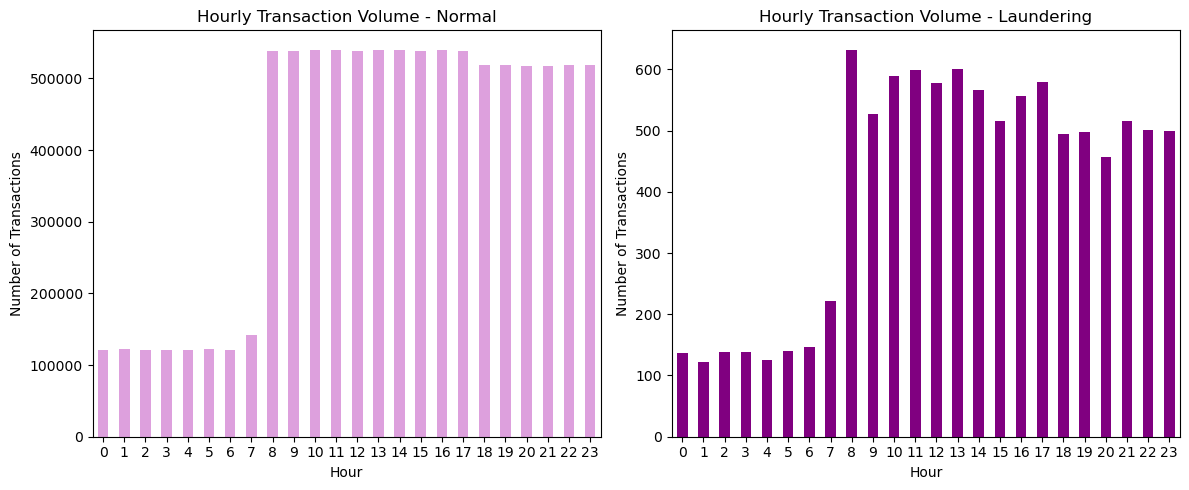

In [ ]:
# Plot transactions per day - Separate for normal vs laundering transactions
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)  # First subplot
df_normal.groupby('Hour').size().plot(kind='bar', color='plum')
plt.title('Hourly Transaction Volume - Normal')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)

plt.subplot(1,2,2)  # Second subplot
df_laundering.groupby('Hour').size().plot(kind='bar', color='purple')
plt.title('Hourly Transaction Volume - Laundering')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


### Laundering transactions peak during regular business hours, similar to normal transactions, but show a more gradual increase starting earlier in the day, suggesting potential strategic timing to blend with legitimate activity.
----

### The distribution of transactions across different days of week


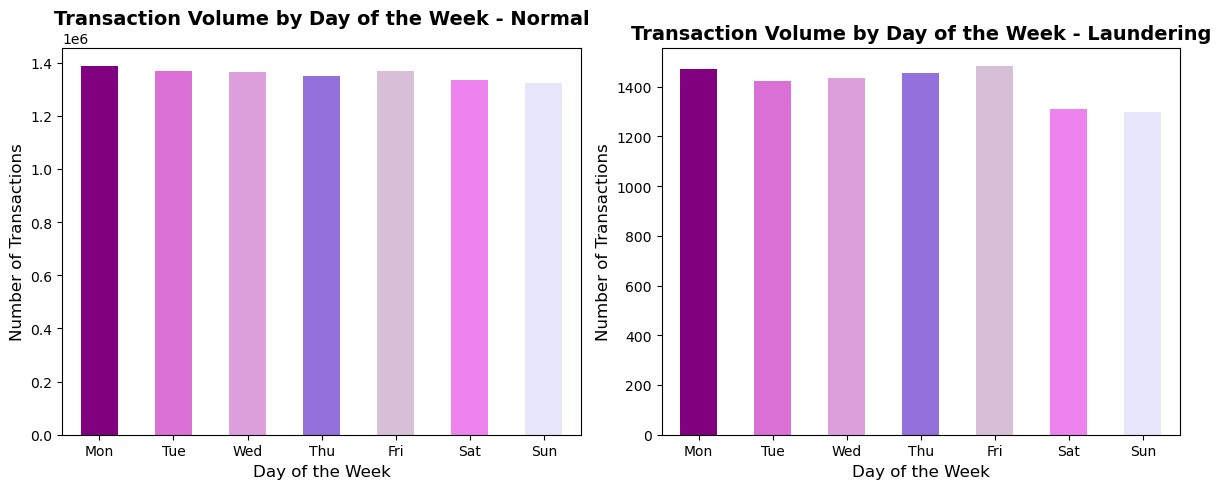

In [ ]:
# Define purple shades for each day
day_colors = ['purple', 'orchid', 'plum', 'mediumpurple', 'thistle', 'violet', 'lavender']

# Define a mapping for day labels
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Group transactions by day of the week
day_normal = df_normal.groupby('DayOfWeek').size().reindex(range(7))
day_laundering = df_laundering.groupby('DayOfWeek').size().reindex(range(7))

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions by Day of the Week
plt.subplot(1, 2, 1)
day_normal.plot(kind='bar', color=day_colors)
plt.title('Transaction Volume by Day of the Week - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels, rotation=0)

# Second subplot: Laundering Transactions by Day of the Week
plt.subplot(1, 2, 2)
day_laundering.plot(kind='bar', color=day_colors)
plt.title('Transaction Volume by Day of the Week - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels, rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Laundering transactions occur consistently throughout the week, mirroring normal transaction trends, but with a slight decrease on weekends, which may indicate reduced financial activity or increased monitoring during non-business days.
---

### Visualize the total number of transactions per different period

In [ ]:
# Categorize into Beginning (1-10), Middle (11-20), End (21-31)
df_laundering['MonthPeriod'] = np.where(df_laundering['DayOfMonth'] <= 10, 'Beginning',
                           np.where(df_laundering['DayOfMonth'] <= 20, 'Middle', 'End'))

# Count number of transactions per period
summary_stats = df_laundering['MonthPeriod'].value_counts()
print("Laundering Transactions per Period:\n", summary_stats)

Laundering Transactions per Period:
 Middle       4248
Beginning    3145
End          2480
Name: MonthPeriod, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


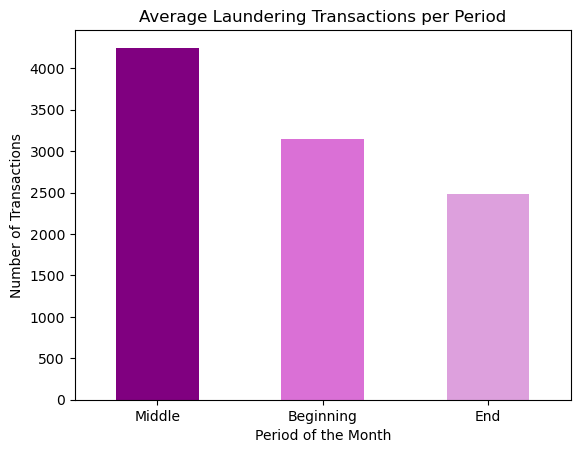

In [ ]:
summary_stats.plot(kind='bar', color=['Purple', 'Orchid', 'plum'])
plt.title("Average Laundering Transactions per Period")
plt.xlabel("Period of the Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.show()

-----

### Most of the laundering transaction happened in the middle of the month

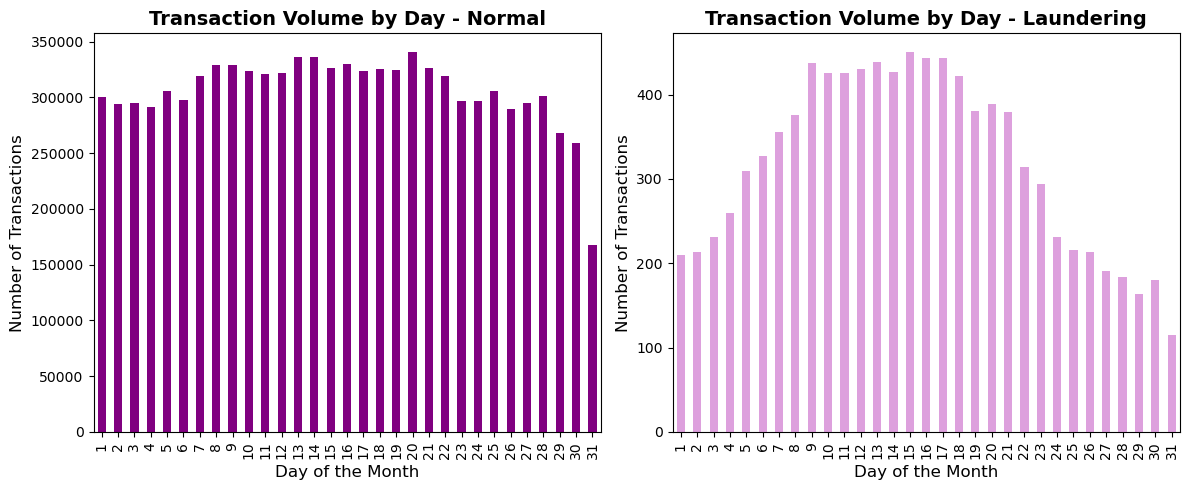

In [ ]:
# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions
plt.subplot(1, 2, 1)
df_normal.groupby('DayOfMonth').size().plot(kind='bar', color='Purple')
plt.title('Transaction Volume by Day - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=90)

# Second subplot: Laundering Transactions
plt.subplot(1, 2, 2)
df_laundering.groupby('DayOfMonth').size().plot(kind='bar', color='Plum')
plt.title('Transaction Volume by Day - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=90)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### We can see that most of the fraudulent transactions happen between the 10th to 20th of the month.
----

## Visualize the weekday and weekend distribution

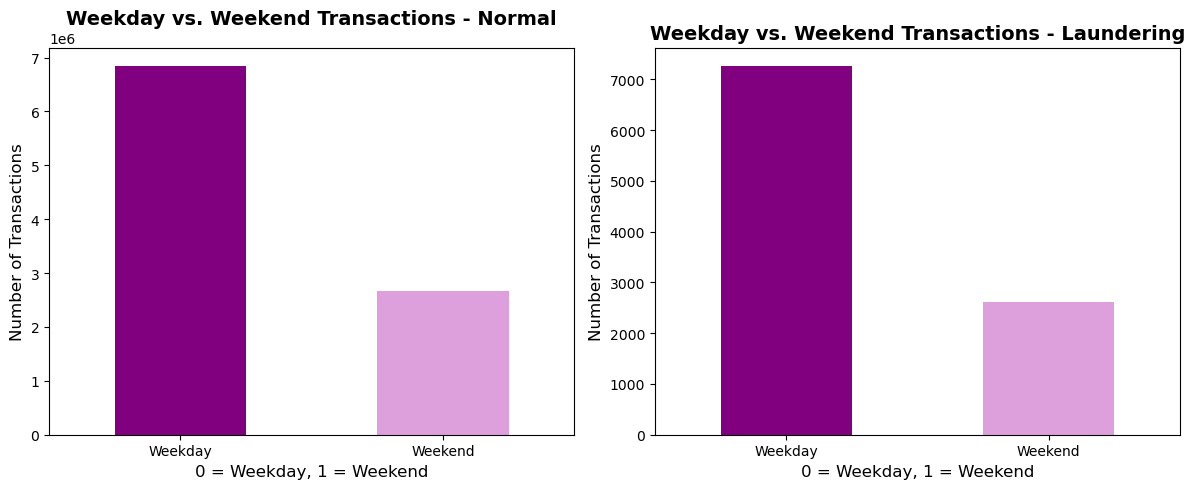

In [ ]:
# Count transactions for Weekday (0) and Weekend (1)
weekend_counts = df['IsWeekend'].value_counts()
laundering_weekend_counts = df_laundering['IsWeekend'].value_counts()

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions (df)
plt.subplot(1, 2, 1)
weekend_counts.plot(kind='bar', color=['Purple', 'Plum'])
plt.title('Weekday vs. Weekend Transactions - Normal', fontsize=14, fontweight='bold')
plt.xlabel('0 = Weekday, 1 = Weekend', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)

# Second subplot: Laundering Transactions (df_laundering)
plt.subplot(1, 2, 2)
laundering_weekend_counts.plot(kind='bar', color=['Purple', 'Plum'])
plt.title('Weekday vs. Weekend Transactions - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('0 = Weekday, 1 = Weekend', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### More transactions occur on weekdays than weekends (both for normal and laundering transactions).
---

## Visualize the monthly distribution

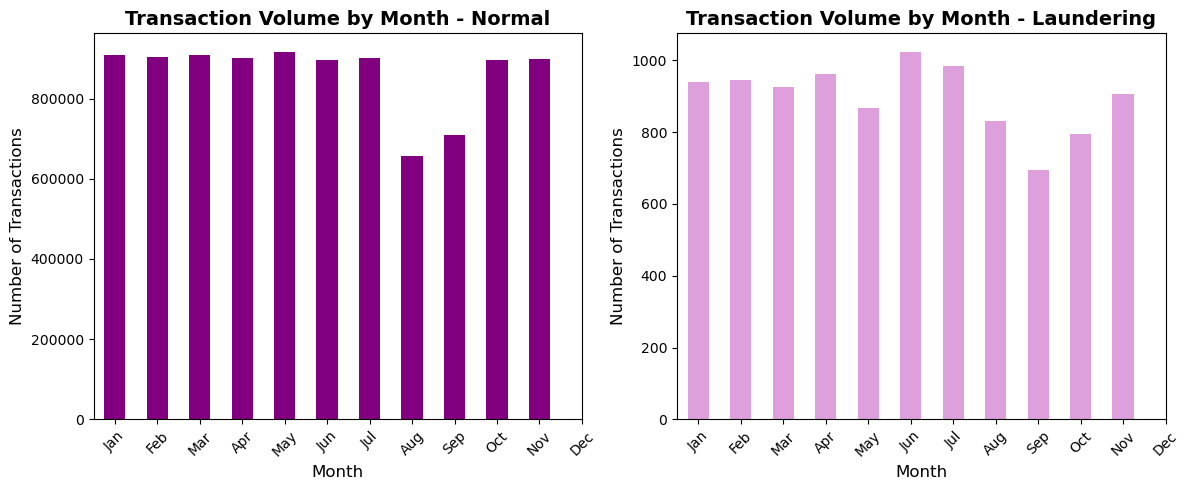

In [ ]:
# Define colors
normal_color = 'Purple'  # Color for normal transactions
laundering_color = 'Plum'  # Color for laundering transactions

# Ensure months are sorted correctly
normal_transactions = df_normal.groupby('Month').size().sort_index()
laundering_transactions = df_laundering.groupby('Month').size().sort_index()

# Define month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions
plt.subplot(1, 2, 1)
normal_transactions.plot(kind='bar', color=normal_color)
plt.title('Transaction Volume by Month - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(12), labels=month_labels, rotation=45)  # Ensure correct order

# Second subplot: Laundering Transactions
plt.subplot(1, 2, 2)
laundering_transactions.plot(kind='bar', color=laundering_color)
plt.title('Transaction Volume by Month - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=range(12), labels=month_labels, rotation=45)  # Ensure correct order

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Laundering transactions generally follow the same monthly pattern as normal transactions, with slight variations, particularly a dip in September, which may indicate lower financial activity during this period.
---


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


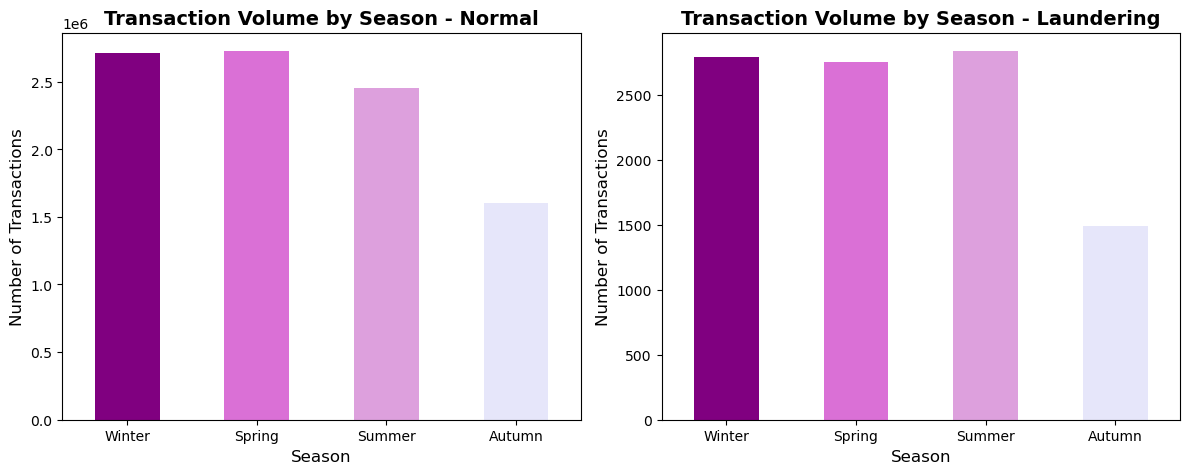

In [ ]:
# Define purple shades for each season
season_colors = ['purple', 'orchid', 'plum', 'lavender']  # Winter, Spring, Summer, Autumn

# Define a mapping from Month to Season
season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

# Create new column 'Season'
df_normal['Season'] = df_normal['Month'].map(season_mapping)
df_laundering['Season'] = df_laundering['Month'].map(season_mapping)

# Group by season
seasonal_normal = df_normal.groupby('Season').size().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])
seasonal_laundering = df_laundering.groupby('Season').size().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

# Create figure for side-by-side comparison
plt.figure(figsize=(12, 5))

# First subplot: Normal Transactions by Season
plt.subplot(1, 2, 1)
seasonal_normal.plot(kind='bar', color=season_colors)
plt.title('Transaction Volume by Season - Normal', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=0)

# Second subplot: Laundering Transactions by Season
plt.subplot(1, 2, 2)
seasonal_laundering.plot(kind='bar', color=season_colors)
plt.title('Transaction Volume by Season - Laundering', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Laundering transactions follow a similar seasonal pattern to normal transactions, peaking in Winter, Spring, and Summer, with a noticeable drop in Autumn, possibly reflecting overall financial activity trends.
----

# Amount

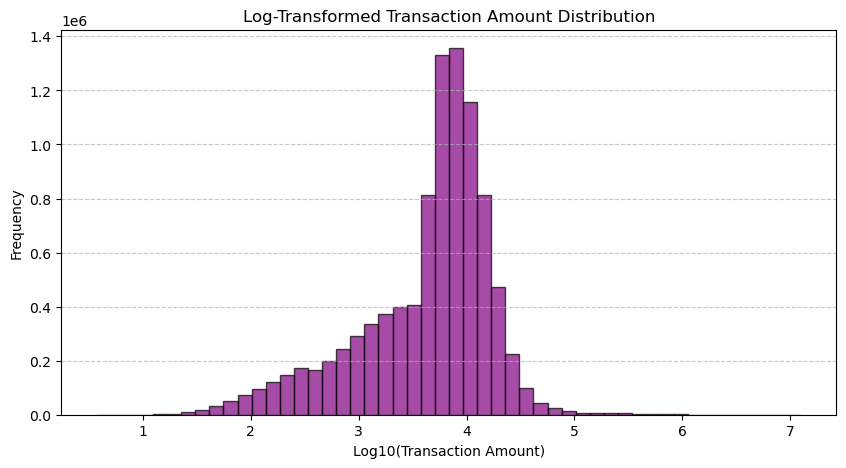

In [ ]:
# Remove zero values to avoid log(0) errors
df_nonzero = df[df['Amount'] > 0]

# Apply log transformation
log_amounts = np.log10(df_nonzero['Amount'])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(log_amounts, bins=50, color='Purple', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Log-Transformed Transaction Amount Distribution')
plt.xlabel('Log10(Transaction Amount)')
plt.ylabel('Frequency')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

-------

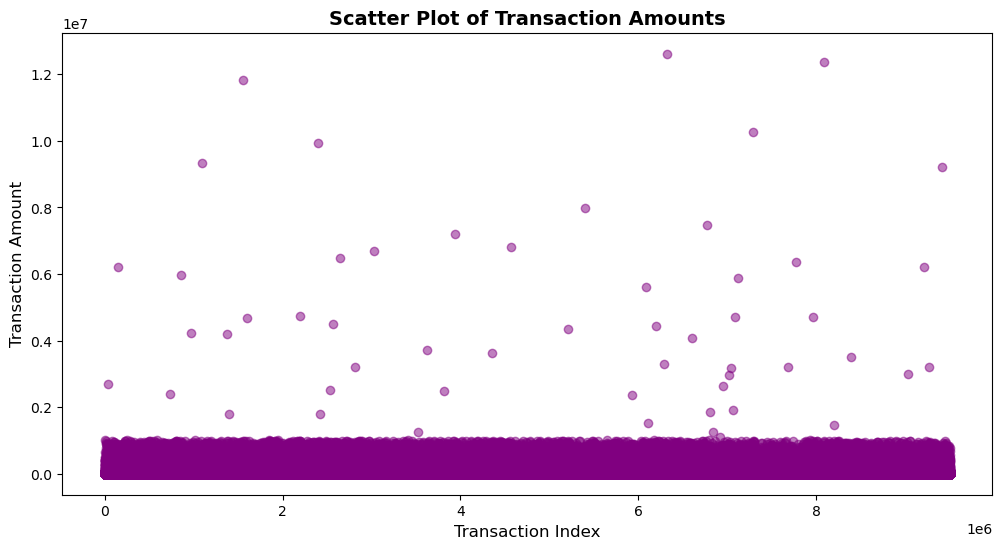

In [ ]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Amount'], color='purple', alpha=0.5)

# Labels and title
plt.title('Scatter Plot of Transaction Amounts', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Index', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)

# Show plot
plt.show()


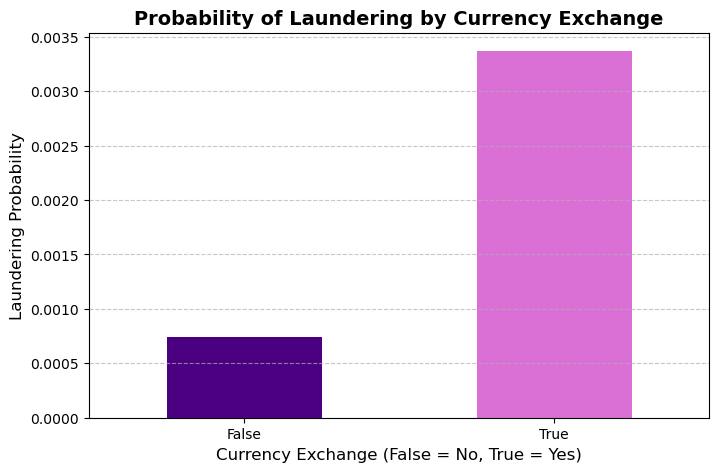

In [ ]:
# Ensure Is_laundering is numeric (convert if necessary)
df['Is_laundering'] = df['Is_laundering'].astype(int)

# Create a new column to flag currency exchange transactions
df['Currency_Exchange'] = df['Payment_currency'] != df['Received_currency']

# Compute the number of laundering vs. normal transactions for each category
laundering_by_exchange = df.groupby('Currency_Exchange')['Is_laundering'].value_counts(normalize=True).unstack()


# Visualize laundering probability by currency exchange status
plt.figure(figsize=(8,5))

# Ensure the correct column is selected (use .get() to avoid KeyError)
if 1 in laundering_by_exchange.columns:
    laundering_by_exchange[1].plot(kind='bar', color=['indigo', 'orchid'])  # Updated colors
else:
    print("Warning: No laundering transactions found (1 is missing).")

plt.title("Probability of Laundering by Currency Exchange", fontsize=14, fontweight='bold')
plt.xlabel("Currency Exchange (False = No, True = Yes)", fontsize=12)
plt.ylabel("Laundering Probability", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#drop the Currency Exchange column for now, and then create in the feature engineering part.
df.drop(columns=['Currency_Exchange'], inplace=True)



### Transactions involving currency exchange have a significantly higher probability of being linked to money laundering compared to transactions where the payment and received currencies are the same.
---

# Laundering Risk by Payment Type
### Analyzing the proportion of laundered transactions across different payment methods


In [ ]:
# Analyze payment types, total amounts, and laundering counts
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)

# Count the number of laundering transactions
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')

# Count the number of normal transactions
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

# Compute the total laundered amount per payment type
laundered_amount_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type')['Amount'].sum().to_frame('Laundered_Amount')

# Combine all pivots into a single DataFrame
combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot, laundered_amount_pivot], how='outer').fillna(0)

# Calculate the ratio of laundered amount to total transaction volume
combined_pivot["Laundered_Amount_to_Total_Transaction_Volume"] = (
    (combined_pivot["Laundered_Amount"] / combined_pivot["Amount"]) * 100
).fillna(0)

# Define the order of columns to display
column_order = ["Laundering_Count", "Normal_Count", "Amount", "Laundered_Amount", "Laundered_Amount_to_Total_Transaction_Volume"]

# Reorder columns
combined_pivot = combined_pivot[column_order]

# Apply color gradient for visualization
cm = sns.light_palette("blue", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm).format({
    "Laundering_Count": "{:,}",
    "Normal_Count": "{:,}",
    "Amount": "${:,.2f}",
    "Laundered_Amount": "${:,.2f}",
    "Laundered_Amount_to_Total_Transaction_Volume": "{:.2f}%"
})

# Display the styled DataFrame
styled_combined_pivot


,Laundering_Count,Normal_Count,Amount,Laundered_Amount,Laundered_Amount_to_Total_Transaction_Volume
Payment_type,,,,,
ACH,"1,159","2,007,648","$18,272,052,011.85","$74,898,404.48",0.41%
Cash Deposit,"1,405","223,801","$485,809,045.64","$6,953,385.33",1.43%
Cash Withdrawal,"1,334","299,143","$46,118,125.58","$205,867.65",0.45%
Cheque,"1,087","2,010,332","$18,328,875,956.82","$78,962,801.01",0.43%
Credit card,"1,136","2,011,773","$18,308,924,931.18","$60,965,592.37",0.33%
Cross-border,"2,628","931,303","$9,476,591,292.70","$57,708,470.49",0.61%
Debit card,"1,124","2,010,979","$18,372,338,763.84","$121,027,514.03",0.66%


#### Cash Deposits (1.43%) and Debit Cards (0.66%) have the highest laundering ratios relative to total transaction volume, while Cross-Border Transactions have the highest laundering count (2,628 cases), making them a high-risk category for money laundering
---

# Visualizing the average amount of transactions per month


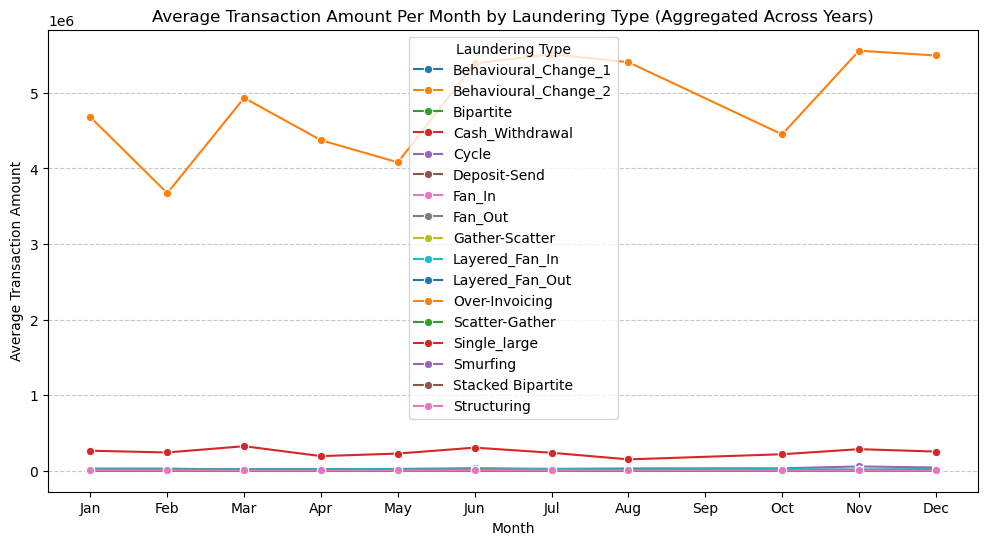

In [ ]:
# Compute the average transaction amount per month for each laundering type
monthly_avg_laundering = df_laundering.groupby(['Month', 'Laundering_type'])['Amount'].mean().unstack()

# Plot the monthly average transaction amounts per laundering type
plt.figure(figsize=(12, 6))

# Plot each laundering type separately
for laundering_type in monthly_avg_laundering.columns:
    sns.lineplot(x=monthly_avg_laundering.index, y=monthly_avg_laundering[laundering_type], marker='o', label=laundering_type)

# Labels and title
plt.title('Average Transaction Amount Per Month by Laundering Type (Aggregated Across Years)')
plt.xlabel('Month')
plt.ylabel('Average Transaction Amount')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Laundering Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### The "Over-Invoicing" laundering type shows significantly higher average transaction amounts compared to other methods, while most other laundering types remain relatively low and stable throughout the year
---

# Top sender and receiver bank locations

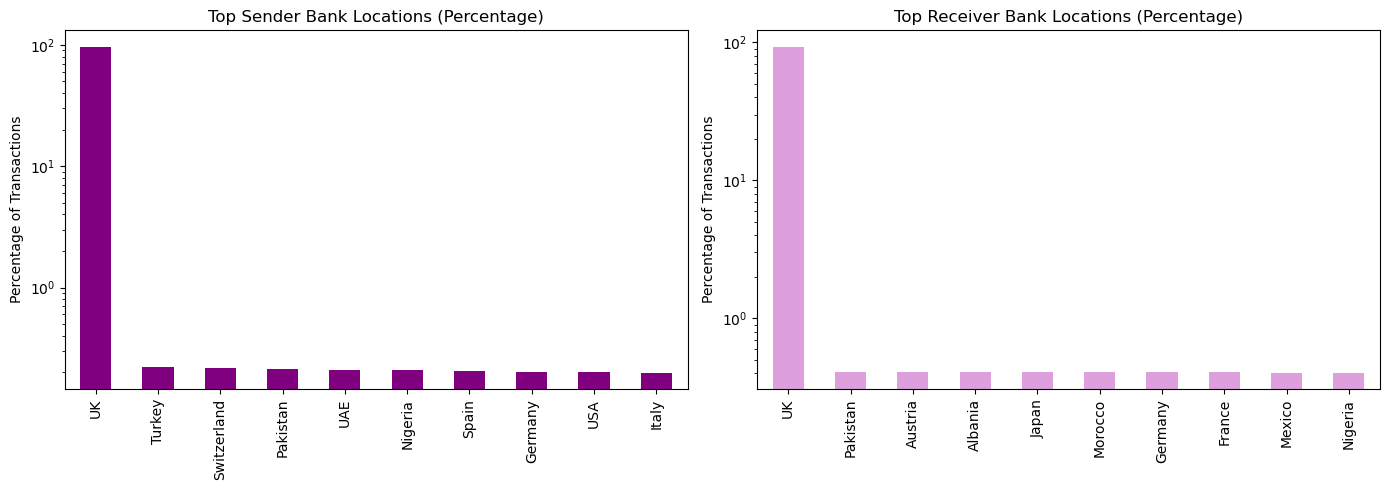

In [ ]:
# Normalize by percentage
sender_counts = df['Sender_bank_location'].value_counts(normalize=True) * 100
receiver_counts = df['Receiver_bank_location'].value_counts(normalize=True) * 100

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sender Locations
sender_counts[:10].plot(kind='bar', ax=axes[0], color='purple')
axes[0].set_title("Top Sender Bank Locations (Percentage)")
axes[0].set_ylabel("Percentage of Transactions")
axes[0].set_yscale("log")  # Log scale for visibility

# Receiver Locations
receiver_counts[:10].plot(kind='bar', ax=axes[1], color='plum')
axes[1].set_title("Top Receiver Bank Locations (Percentage)")
axes[1].set_ylabel("Percentage of Transactions")
axes[1].set_yscale("log")  # Log scale for visibility

plt.tight_layout()
plt.show()

# Top money laundering country

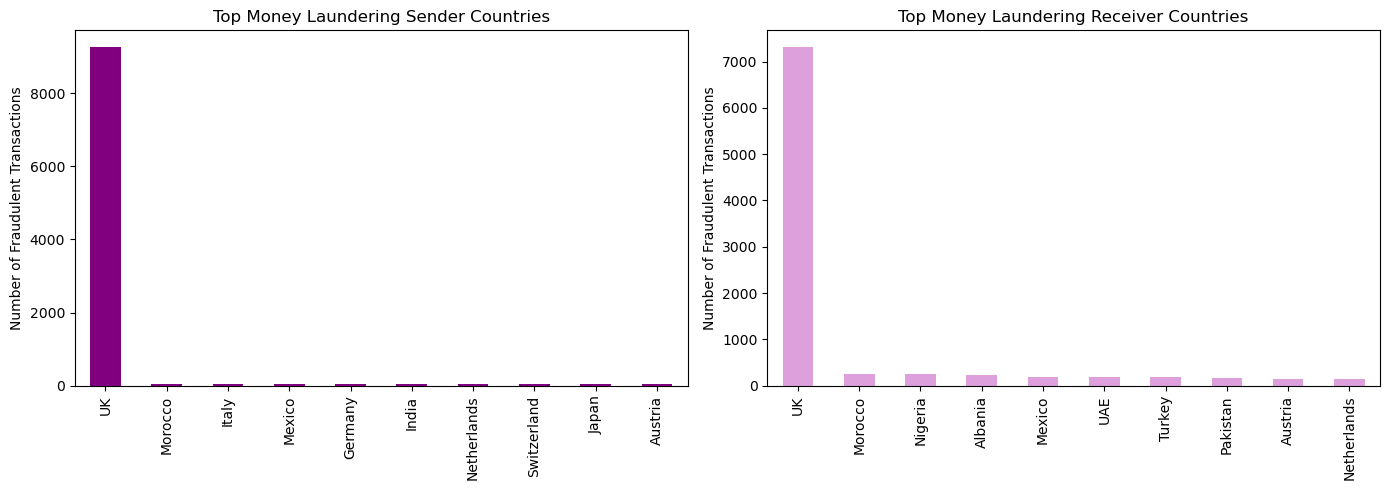

In [ ]:
# Count money laundering transactions per country
laundering_senders = df_Laundering['Sender_bank_location'].value_counts()
laundering_receivers = df_Laundering['Receiver_bank_location'].value_counts()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sender Countries in Money Laundering
laundering_senders[:10].plot(kind='bar', ax=axes[0], color='purple')
axes[0].set_title("Top Money Laundering Sender Countries")
axes[0].set_ylabel("Number of Fraudulent Transactions")

# Receiver Countries in Money Laundering
laundering_receivers[:10].plot(kind='bar', ax=axes[1], color='plum')
axes[1].set_title("Top Money Laundering Receiver Countries")
axes[1].set_ylabel("Number of Fraudulent Transactions")

plt.tight_layout()
plt.show()

#### The UK dominates both sender and receiver bank locations, indicating a central role in transactions, while other countries have significantly lower transaction volumes.
----

# Number of transactions per payment type

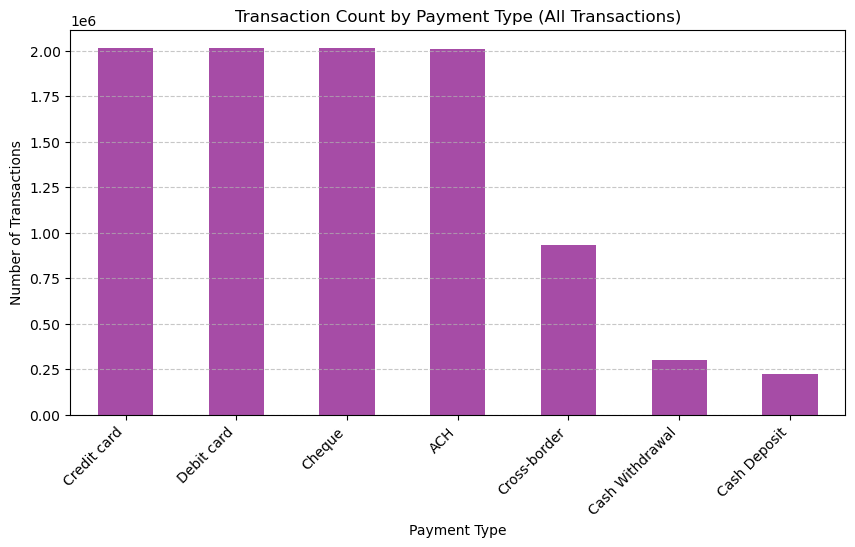

In [ ]:
# Number of transaction by payment type
plt.figure(figsize=(10,5))
df['Payment_type'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title("Transaction Count by Payment Type (All Transactions)")
plt.ylabel("Number of Transactions")
plt.xlabel("Payment Type")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### The first plot shows that credit card, debit card, cheque, and ACH transactions are the most common payment types overall, while cross-border and cash transactions are less frequent.

# Number of fradulent transactions by payment Type

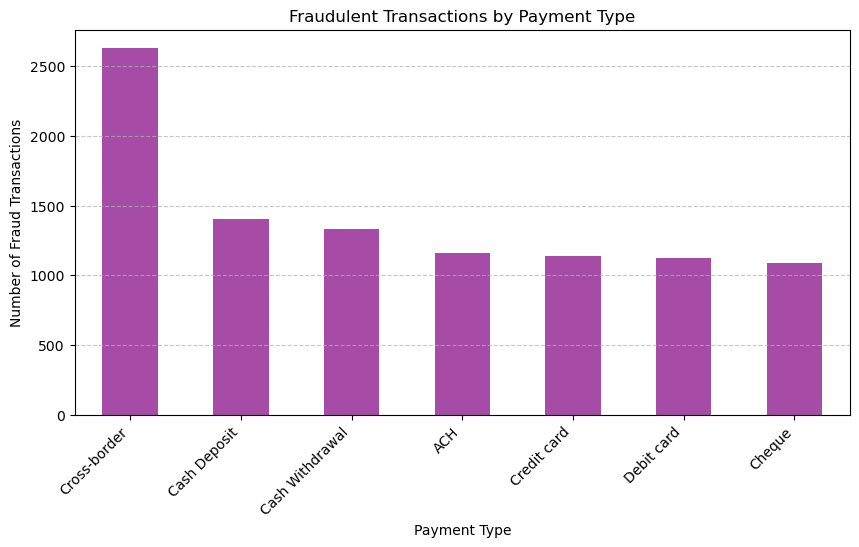

In [ ]:
#Number of fradulent transactions by payment Type
plt.figure(figsize=(10,5))
df_Laundering['Payment_type'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title("Fraudulent Transactions by Payment Type")
plt.ylabel("Number of Fraud Transactions")
plt.xlabel("Payment Type")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### The second plot highlights that fraudulent transactions are more concentrated in cross-border payments, cash deposits, and cash withdrawals, suggesting that these payment methods are more vulnerable to money laundering activities.
----

# Top 10 Money Laundering Techniques

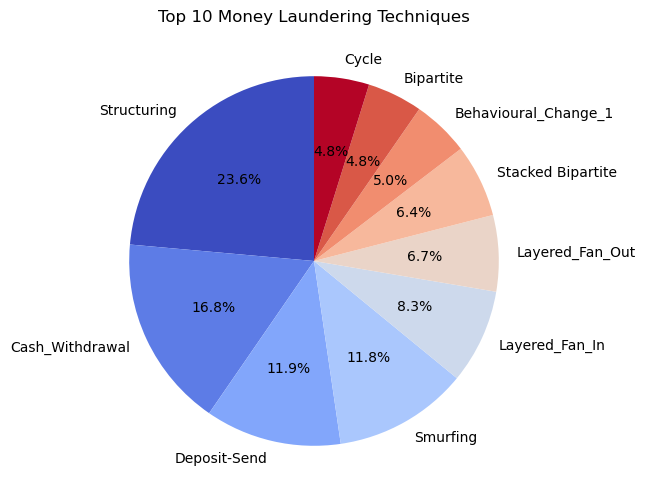

In [ ]:
plt.figure(figsize=(10,6))
df_Laundering['Laundering_type'].value_counts().head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap="coolwarm")
plt.title("Top 10 Money Laundering Techniques")
plt.ylabel("")  # Remove y-axis label for clarity
plt.show()

#### The pie chart highlights that structuring is the most commonly used money laundering technique, followed by cash withdrawals and deposit-send transactions, indicating a preference for breaking large sums into smaller transactions to avoid detection.
----

# Laundering Techniques by Sender Country

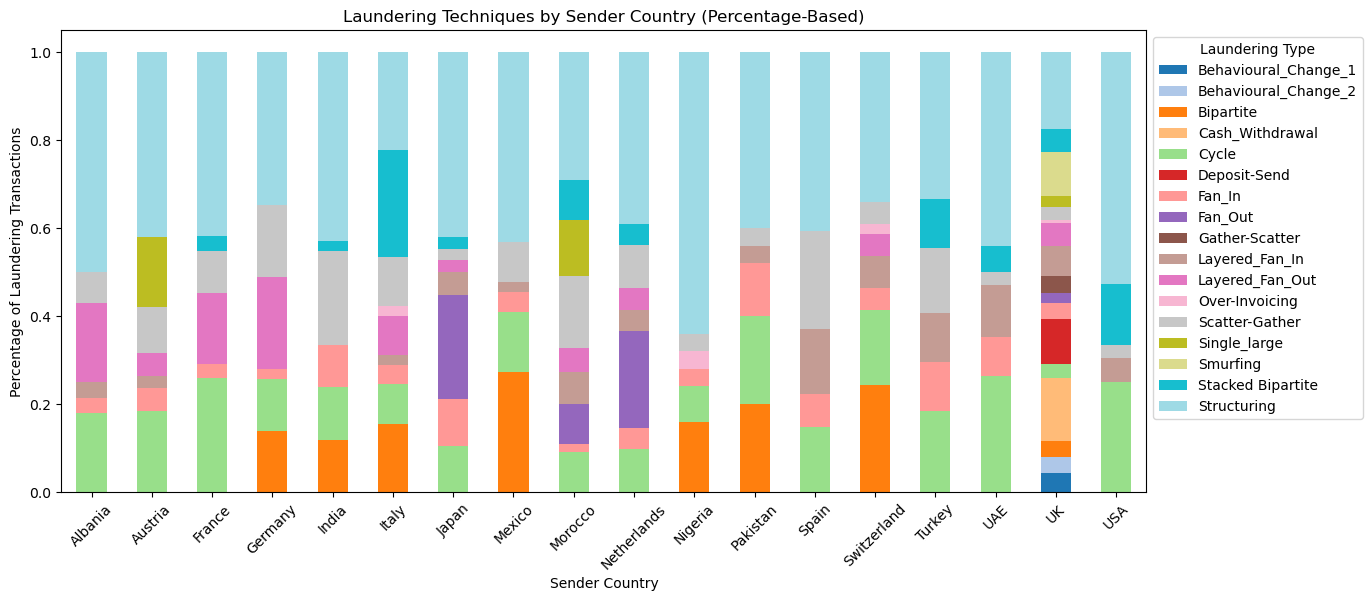

In [ ]:
# Group by Sender Country and Laundering Type, then count occurrences
filtered_laundering_sender = df_Laundering.groupby(['Sender_bank_location', 'Laundering_type']).size().unstack(fill_value=0)

# Normalize laundering types within each country
normalized_laundering_sender = filtered_laundering_sender.div(filtered_laundering_sender.sum(axis=1), axis=0)

# Plot stacked bar chart (percentage-based)
normalized_laundering_sender.plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")
plt.title("Laundering Techniques by Sender Country (Percentage-Based)")
plt.xlabel("Sender Country")
plt.ylabel("Percentage of Laundering Transactions")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1, 1))
plt.show()


#### The stacked bar chart shows that structuring is the most dominant laundering technique across most sender countries, while other methods like cash withdrawal, fan-in, and smurfing vary in distribution, suggesting regional laundering strategy preferences.
----


# Laundering Techniques by Receiver Country

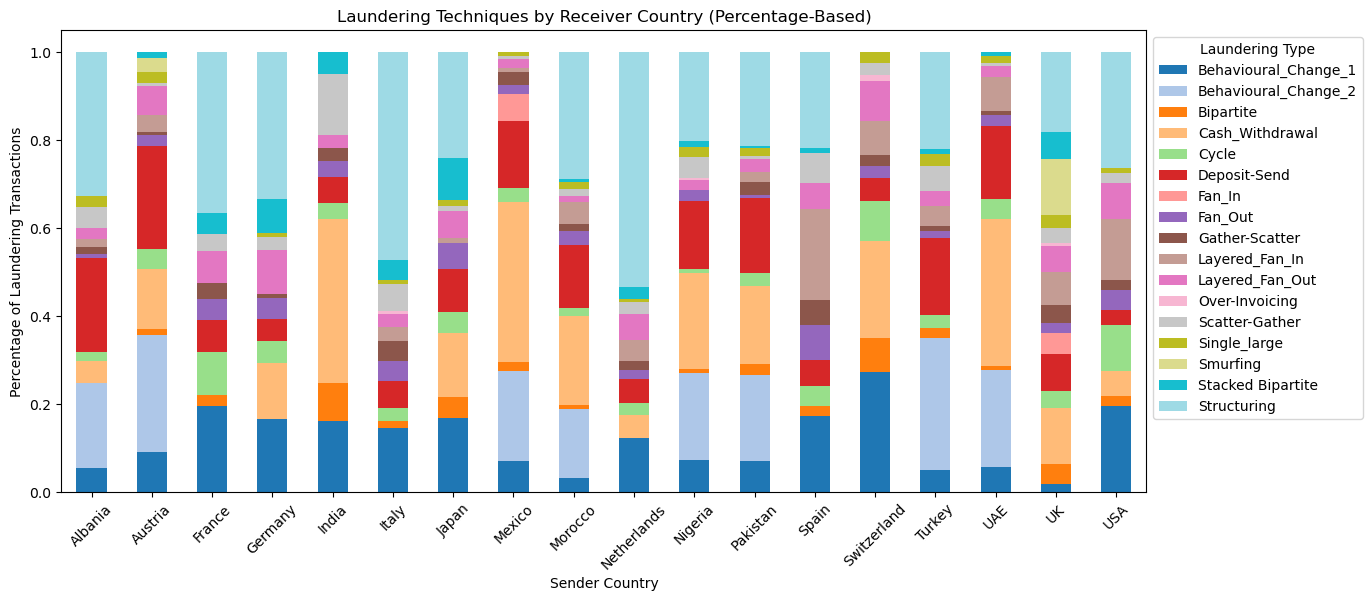

In [ ]:
# Group by Sender Country and Laundering Type, then count occurrences
filtered_laundering_sender = df_Laundering.groupby(['Receiver_bank_location', 'Laundering_type']).size().unstack(fill_value=0)

# Normalize laundering types within each country
normalized_laundering_sender = filtered_laundering_sender.div(filtered_laundering_sender.sum(axis=1), axis=0)

# Plot stacked bar chart (percentage-based)
normalized_laundering_sender.plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")
plt.title("Laundering Techniques by Receiver Country (Percentage-Based)")
plt.xlabel("Sender Country")
plt.ylabel("Percentage of Laundering Transactions")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1, 1))
plt.show()

#### The distribution of laundering techniques varies significantly by receiver country, with structuring being the most common method, while techniques like deposit-send, fan-in, and layering show distinct patterns across different regions.
------

#### Dropping `Laundering_type` Column

We drop the `Laundering_type` column because:

It is **highly correlated** with `Is_laundering` and could introduce **data leakage**.  
Our main goal is **binary classification** (laundering vs. non-laundering), so this column is redundant.  
Keeping it might make the model overly reliant on this feature instead of learning real transaction patterns.  

If needed for **multi-class classification (predicting laundering types)**, we could encode it later.  


In [ ]:
df.drop(columns=['Laundering_type'], inplace=True)

----

# Feature Engineering

#### **Creating Non-Leaking Features**

#### Binary Feature: Sender & Receiver Location Match
#### - Helps detect transactions that stay within the same region.
#### - 1 = Same location, 0 = Different location.


In [ ]:
df['Sender_Receiver_Same_Location'] = (df['Sender_bank_location'] == df['Receiver_bank_location']).astype(int)


####  **Binary Feature: Sender & Receiver Currency Match**
#### - Identifies currency conversion transactions, which may be more suspicious.
#### - 1 = Same currency, 0 = Different currency.


In [ ]:
df['Sender_Receiver_Same_Currency'] = (df['Payment_currency'] == df['Received_currency']).astype(int)


In [ ]:
# Display results
df[['Sender_bank_location', 'Receiver_bank_location', 'Sender_Receiver_Same_Location',
    'Payment_currency', 'Received_currency', 'Sender_Receiver_Same_Currency']].head()

,Sender_bank_location,Receiver_bank_location,Sender_Receiver_Same_Location,Payment_currency,Received_currency,Sender_Receiver_Same_Currency
0,UK,UK,1,UK pounds,UK pounds,1
1,UK,UAE,0,UK pounds,Dirham,0
2,UK,UK,1,UK pounds,UK pounds,1
3,UK,UK,1,UK pounds,UK pounds,1
4,UK,UK,1,UK pounds,UK pounds,1


### Binary feature: to see if a transaction happened in the working hour or not?

In [ ]:
df['Is_Business_Hours'] = df['Hour'].between(9, 17).astype(int)

### Binary feature: to see if a transaction happened in the morning or not?

In [ ]:
df['Is_Morning'] = (df['Hour'] < 12).astype(int)

-----

#### Label Encoding for Payment and Received Currency

Since `Payment_currency` and `Received_currency` contain multiple unique values, we use **Label Encoding** instead of One-Hot Encoding to avoid creating too many new columns.

#### **Why Label Encoding?**
- One-Hot Encoding would generate too many features, making the dataset unnecessarily large.
- Label Encoding assigns a **unique integer** to each currency while preserving its identity.

#### **What We Did?**
1. **Fitted a `LabelEncoder`** on both columns to transform categorical values into numbers.
2. **Stored the original-to-encoded mappings** for documentation and interpretability.
3. **Printed the mapping** so we can reference what each encoded number represents.

Below is the mapping of currencies to their assigned numbers:


In [ ]:
# Initialize LabelEncoders
label_encoder_payment = LabelEncoder()
label_encoder_received = LabelEncoder()

# Fit label encoders
df['Payment_currency'] = label_encoder_payment.fit_transform(df['Payment_currency'])
df['Received_currency'] = label_encoder_received.fit_transform(df['Received_currency'])

# Create a mapping dictionary for documentation
payment_currency_mapping = dict(zip(label_encoder_payment.classes_, label_encoder_payment.transform(label_encoder_payment.classes_)))
received_currency_mapping = dict(zip(label_encoder_received.classes_, label_encoder_received.transform(label_encoder_received.classes_)))

# Print the mapping for markdown documentation
print("### Payment Currency Encoding:")
for key, value in payment_currency_mapping.items():
    print(f"{key} → {value}")

print("\n### Received Currency Encoding:")
for key, value in received_currency_mapping.items():
    print(f"{key} → {value}")


### Payment Currency Encoding:
Albanian lek → 0
Dirham → 1
Euro → 2
Indian rupee → 3
Mexican Peso → 4
Moroccan dirham → 5
Naira → 6
Pakistani rupee → 7
Swiss franc → 8
Turkish lira → 9
UK pounds → 10
US dollar → 11
Yen → 12

### Received Currency Encoding:
Albanian lek → 0
Dirham → 1
Euro → 2
Indian rupee → 3
Mexican Peso → 4
Moroccan dirham → 5
Naira → 6
Pakistani rupee → 7
Swiss franc → 8
Turkish lira → 9
UK pounds → 10
US dollar → 11
Yen → 12


----

#### One-Hot Encoding for Some of the Categorical Features

To convert categorical values into numerical format, we applied **One-Hot Encoding** to the following columns:
- `Payment_type`
- `Sender_bank_location`
- `Receiver_bank_location`

#### Why One-Hot Encoding?
These features have a **limited number of categories**, making One-Hot Encoding an effective choice.  
It ensures the model does not assume an **ordinal relationship** between categories.  

We used `drop_first=True` to prevent multicollinearity by removing one redundant category per feature.  


In [ ]:
# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=['Payment_type', 'Sender_bank_location', 'Receiver_bank_location'], drop_first=True)

# Display updated column names after encoding
print("Updated Columns After One-Hot Encoding:")
print(df.columns)

Updated Columns After One-Hot Encoding:
Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Is_laundering', 'Datetime',
       'Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend',
       'Sender_Receiver_Same_Location', 'Sender_Receiver_Same_Currency',
       'Is_Business_Hours', 'Is_Morning', 'Payment_type_Cash Deposit',
       'Payment_type_Cash Withdrawal', 'Payment_type_Cheque',
       'Payment_type_Credit card', 'Payment_type_Cross-border',
       'Payment_type_Debit card', 'Sender_bank_location_Austria',
       'Sender_bank_location_France', 'Sender_bank_location_Germany',
       'Sender_bank_location_India', 'Sender_bank_location_Italy',
       'Sender_bank_location_Japan', 'Sender_bank_location_Mexico',
       'Sender_bank_location_Morocco', 'Sender_bank_location_Netherlands',
       'Sender_bank_location_Nigeria', 'Sender_bank_location_Pakistan',
       'Sender_bank_location_Spain', 'Sender_bank_location_S

------

### Splitting the Data (Train, Validation, Test)
We divide the dataset into:
- **70% Training Data** – Used for model learning.
- **15% Validation Data** – Used for hyperparameter tuning.
- **15% Test Data** – Used for final model evaluation.


In [ ]:
# Define target variable
y = df['Is_laundering']
X = df.drop(columns=['Is_laundering'])  # Keep sender/receiver for now

# Split into Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Print dataset shapes
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (6653396, 57), Validation Set: (1425728, 57), Test Set: (1425728, 57)


In [ ]:
df[df['Is_laundering'] == 1].describe()


,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Is_laundering,Hour,DayOfWeek,Month,DayOfMonth,...,Receiver_bank_location_Morocco,Receiver_bank_location_Netherlands,Receiver_bank_location_Nigeria,Receiver_bank_location_Pakistan,Receiver_bank_location_Spain,Receiver_bank_location_Switzerland,Receiver_bank_location_Turkey,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA
count,9.873000e+03,9.873000e+03,9.873000e+03,9873.000000,9873.000000,9873.0,9873.000000,9873.000000,9873.000000,9873.000000,...,9873.000000,9873.00000,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000
mean,5.148871e+09,4.971873e+09,4.058767e+04,9.459536,8.352476,1.0,13.841183,2.928492,6.078598,14.905702,...,0.025625,0.01499,0.025423,0.017117,0.008812,0.007799,0.017928,0.019751,0.740201,0.008812
std,2.813039e+09,2.842449e+09,4.191811e+05,1.953317,3.104856,0.0,5.727742,1.980290,3.479813,7.637656,...,0.158023,0.12152,0.157414,0.129715,0.093462,0.087972,0.132695,0.139150,0.438547,0.093462
min,9.217200e+04,9.217200e+04,1.582000e+01,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.824946e+09,2.492084e+09,2.723790e+03,10.000000,8.000000,1.0,10.000000,1.000000,3.000000,9.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.107246e+09,4.793402e+09,5.322790e+03,10.000000,10.000000,1.0,14.000000,3.000000,6.000000,15.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,7.543489e+09,7.407152e+09,9.789673e+03,10.000000,10.000000,1.0,19.000000,5.000000,8.000000,21.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.997320e+09,9.998804e+09,1.261850e+07,12.000000,12.000000,1.0,23.000000,6.000000,12.000000,31.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


-----

#### Creating Historical Features (On Training Data Only)
To prevent data leakage, we **only create history-based features on the training set**, such as:
- `Sender_Total_Transactions`: Total transactions by sender.
- `Sender_Avg_Amount`: Average transaction amount.
- `Sender_Std_Amount`: Standard deviation of transaction amounts.
- `Time_Since_Last_Transaction`: Time difference (minutes) between consecutive transactions.
- `High_Amount_Flag`: Flags unusually large transactions.


In [ ]:
# Total transactions per sender
X_train['Sender_Total_Transactions'] = X_train.groupby('Sender_account')['Amount'].transform('count')

# Average transaction amount per sender
X_train['Sender_Avg_Amount'] = X_train.groupby('Sender_account')['Amount'].transform('mean')

# Standard deviation of transaction amounts per sender
X_train['Sender_Std_Amount'] = X_train.groupby('Sender_account')['Amount'].transform('std').fillna(0)

# Time since last transaction (minutes)
X_train = X_train.sort_values(['Sender_account', 'Datetime'])
X_train['Time_Since_Last_Transaction'] = X_train.groupby('Sender_account')['Datetime'].diff().dt.total_seconds() / 60
X_train['Time_Since_Last_Transaction'] = X_train['Time_Since_Last_Transaction'].fillna(X_train['Time_Since_Last_Transaction'].median())

# Flag high-value transactions
X_train['High_Amount_Flag'] = (X_train['Amount'] > (X_train['Sender_Avg_Amount'] + 2 * X_train['Sender_Std_Amount'])).astype(int)


-----

 #### Applying Features to Validation & Test Sets
After computing sender-based features on training data, we **map the same transformations** to validation and test sets using training statistics.


In [ ]:
# Apply sender-based statistics to validation and test sets using training values
for df in [X_val, X_test]:
    df['Sender_Total_Transactions'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Sender_Total_Transactions'].mean()).fillna(0)
    df['Sender_Avg_Amount'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Sender_Avg_Amount'].mean()).fillna(0)
    df['Sender_Std_Amount'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Sender_Std_Amount'].mean()).fillna(0)
    df['Time_Since_Last_Transaction'] = df['Sender_account'].map(X_train.groupby('Sender_account')['Time_Since_Last_Transaction'].median()).fillna(0)

    # Ensure High_Amount_Flag does not cause NaN issues
    df['High_Amount_Flag'] = ((df['Amount'] > (df['Sender_Avg_Amount'] + 2 * df['Sender_Std_Amount']))).astype(int)


-----

#### Log-Transformed Amount (`Log_Amount`)

To reduce skewness and improve model performance, we apply log transformation to the `Amount` column:

1. **Log Transformation:**  
   - `Log_Amount = log(1 + Amount)`  
   - Stabilizes extreme transaction values.  

2. **Standardization:**  
   - The log-transformed values are standardized using `StandardScaler()`.  
   - Only the training set is used to fit the scaler, and the same scaler is applied to validation & test.  

This ensures all datasets are processed consistently while avoiding data leakage!


In [ ]:
# 1) Log-transform the amount column in the training set
X_train['Log_Amount'] = np.log1p(X_train['Amount'])

# 2) Standardize the log-transformed amount for stability
scaler = StandardScaler()
X_train['Log_Amount'] = scaler.fit_transform(X_train[['Log_Amount']])

# 3) Apply the SAME log transformation to validation & test sets
X_val['Log_Amount'] = np.log1p(X_val['Amount'])
X_test['Log_Amount'] = np.log1p(X_test['Amount'])

# 4) Standardize using the SAME scaler from training
X_val['Log_Amount'] = scaler.transform(X_val[['Log_Amount']])
X_test['Log_Amount'] = scaler.transform(X_test[['Log_Amount']])

# Verify the transformation
print("Log_Amount feature applied correctly across all sets!")


Log_Amount feature applied correctly across all sets!


In [ ]:
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (6653396, 63), Validation Set: (1425728, 63), Test Set: (1425728, 63)


-----

# Additional features:

#### Sender Behavior Features
Sender_Avg_Amount:
Average amount sent by each sender across past transactions. Helps identify deviation from normal behavior.

Sender_Std_Amount:
Standard deviation of transaction amounts per sender. High variability may indicate suspicious activity.

Transaction_Amount_vs_Avg:
Ratio of current log transaction amount to sender's average. Flags unusually large or small transactions.

Is_Structuring_Likely:
Indicates if the sender shows high variability relative to their average. Can reveal structuring (smurfing) behavior.

Is_Small_Transaction:
Marks if the transaction amount is below $1000. Small transfers are often used to avoid detection.

Num_Small_Transactions:
Total number of small transactions made by the sender. Frequent small transfers may be suspicious.

Sender_Median_Amount:
Median amount sent by each sender. More robust to outliers compared to the mean.

Amount_vs_Median:
Ratio of current amount to the sender's median. Flags transactions that diverge from normal patterns.

#### Cash Behavior Features
Is_Cash_Withdrawal:
Indicates if the transaction is a cash withdrawal. Cash is harder to trace and often used in laundering.

Cash_Withdrawal_Ratio:
Proportion of a sender’s transactions that are cash withdrawals. Higher ratios can raise red flags.

Cash_Withdrawal_On_Weekend:
Marks if a cash withdrawal occurred on a weekend. Unusual timing may suggest evasion.

#### Network & Relationship Features

Sender_Receiver_Pair(it was created to create Sender_Receiver_Repeated_Count, but if it is included it creates bias beacuause it works as an ID ):
Combines sender and receiver into a unique ID for tracking pairs. Used to identify repeated links.

Sender_Receiver_Repeated_Count:
Number of times a specific sender-receiver pair appears. Frequent interactions may form laundering loops.

Has_Reciprocity:
Checks if the receiver has also sent money back to the sender. Mutual transfers can suggest circular movement.

Receiver_Unique_SendersL:
Number of unique senders for each receiver. High values might indicate mule or aggregator accounts.

Sender_Unique_Receivers:
Number of unique receivers each sender transfers to. May signal attempts to scatter funds.

In [ ]:
def feature_engineering_laundering(df, reference_df):
    df = df.copy()

    # Use train as reference for val/test to avoid leakage
    ref = reference_df.copy()
    pair_col = 'Sender_Receiver_Pair'

    # Precompute values from reference (typically training set)
    sender_avg_amount = ref.groupby('Sender_account')['Amount'].mean()
    sender_std_amount = ref.groupby('Sender_account')['Amount'].std().fillna(0)
    is_small_trans = (ref['Amount'] < 1000).astype(int)
    sender_num_small = ref.assign(Is_Small_Transaction=is_small_trans).groupby('Sender_account')['Is_Small_Transaction'].sum()
    is_cash_withdraw = ref['Payment_type_Cash Withdrawal'] if 'Payment_type_Cash Withdrawal' in ref else pd.Series(0, index=ref.index)
    sender_cash_ratio = ref.assign(Is_Cash_Withdrawal=is_cash_withdraw).groupby('Sender_account')['Is_Cash_Withdrawal'].mean()
    sender_median_amount = ref.groupby('Sender_account')['Amount'].median()
    pair_counts = ref.assign(Sender_Receiver_Pair=ref['Sender_account'].astype(str) + "_" + ref['Receiver_account'].astype(str)) \
                     .groupby('Sender_Receiver_Pair')['Amount'].count()
    receiver_unique_senders = ref.groupby('Receiver_account')['Sender_account'].nunique()
    sender_unique_receivers = ref.groupby('Sender_account')['Receiver_account'].nunique()

    # Apply to input dataframe
    df['Sender_Avg_Amount'] = df['Sender_account'].map(sender_avg_amount).fillna(0)
    df['Sender_Std_Amount'] = df['Sender_account'].map(sender_std_amount).fillna(0)
    df['Transaction_Amount_vs_Avg'] = df['Log_Amount'] / (df['Sender_Avg_Amount'] + 1e-6)
    df['Is_Structuring_Likely'] = (df['Sender_Std_Amount'] / (df['Sender_Avg_Amount'] + 1e-6) > 1.5).astype(int)
    df['Log_Amount_Close_to_Threshold'] = ((df['Log_Amount'] > 9) & (df['Log_Amount'] < 9.3)).astype(int)
    df['Is_Small_Transaction'] = (df['Amount'] < 1000).astype(int)
    df['Num_Small_Transactions'] = df['Sender_account'].map(sender_num_small).fillna(0)
    df['Is_Cash_Withdrawal'] = df['Payment_type_Cash Withdrawal'] if 'Payment_type_Cash Withdrawal' in df.columns else 0
    df['Cash_Withdrawal_Ratio'] = df['Sender_account'].map(sender_cash_ratio).fillna(0)
    df['Cash_Withdrawal_On_Weekend'] = ((df['IsWeekend'] == 1) & (df['Is_Cash_Withdrawal'] == 1)).astype(int)
    df[pair_col] = df['Sender_account'].astype(str) + "_" + df['Receiver_account'].astype(str)
    df['Sender_Receiver_Repeated_Count'] = df[pair_col].map(pair_counts).fillna(0)
    reverse_pair = df['Receiver_account'].astype(str) + "_" + df['Sender_account'].astype(str)
    df['Has_Reciprocity'] = reverse_pair.isin(pair_counts.index).astype(int)
    df['Receiver_Unique_Senders'] = df['Receiver_account'].map(receiver_unique_senders).fillna(0)
    df['Sender_Unique_Receivers'] = df['Sender_account'].map(sender_unique_receivers).fillna(0)
    df['Sender_Median_Amount'] = df['Sender_account'].map(sender_median_amount).fillna(0)
    df['Amount_vs_Median'] = (df['Amount'] / (df['Sender_Median_Amount'] + 1e-6)).fillna(0)

    return df


In [ ]:
X_train = feature_engineering_laundering(X_train, X_train)  # use self for train
X_val = feature_engineering_laundering(X_val, X_train)      # use train as reference
X_test = feature_engineering_laundering(X_test, X_train)    # same here


In [ ]:
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (6653396, 78), Validation Set: (1425728, 78), Test Set: (1425728, 78)


-------

#### Dropping `Sender_account` and `Receiver_account`
Since the historical features are created, we **remove the sender and receiver account columns** to avoid data leakage and redundancy.

In [ ]:
# Drop sender and receiver account columns after creating relevant features
X_train.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)
X_val.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)
X_test.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)

# Verify dataset shape after dropping unnecessary columns
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (6653396, 76), Validation Set: (1425728, 76), Test Set: (1425728, 76)


In [ ]:
# Display first few rows to check feature values
X_train.head()

,Time,Date,Amount,Payment_currency,Received_currency,Datetime,Hour,DayOfWeek,Month,DayOfMonth,...,Is_Cash_Withdrawal,Cash_Withdrawal_Ratio,Cash_Withdrawal_On_Weekend,Sender_Receiver_Pair,Sender_Receiver_Repeated_Count,Has_Reciprocity,Receiver_Unique_Senders,Sender_Unique_Receivers,Sender_Median_Amount,Amount_vs_Median
8572082,09:51:28,2023-07-22,3319.06,10,2,2023-07-22 09:51:28,9,5,7,22,...,0,0.0,0,9018_2388293593,1,0,1,1,3319.060,1.000000
4191567,23:31:38,2023-02-24,3878.00,10,10,2023-02-24 23:31:38,23,4,2,24,...,0,0.0,0,28511_3072405466,4,0,18,1,5153.495,0.752499
5018226,20:51:59,2023-03-24,4109.92,10,10,2023-03-24 20:51:59,20,4,3,24,...,0,0.0,0,28511_3072405466,4,0,18,1,5153.495,0.797502
6835459,23:02:45,2023-05-24,6755.32,10,10,2023-05-24 23:02:45,23,2,5,24,...,0,0.0,0,28511_3072405466,4,0,18,1,5153.495,1.310823
7755804,19:19:18,2023-06-24,6197.07,10,10,2023-06-24 19:19:18,19,5,6,24,...,0,0.0,0,28511_3072405466,4,0,18,1,5153.495,1.202498


In [ ]:
# Show all column names in the training dataset
print("Current columns in X_train:")
print(X_train.columns)

Current columns in X_train:
Index(['Time', 'Date', 'Amount', 'Payment_currency', 'Received_currency',
       'Datetime', 'Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend',
       'Sender_Receiver_Same_Location', 'Sender_Receiver_Same_Currency',
       'Is_Business_Hours', 'Is_Morning', 'Payment_type_Cash Deposit',
       'Payment_type_Cash Withdrawal', 'Payment_type_Cheque',
       'Payment_type_Credit card', 'Payment_type_Cross-border',
       'Payment_type_Debit card', 'Sender_bank_location_Austria',
       'Sender_bank_location_France', 'Sender_bank_location_Germany',
       'Sender_bank_location_India', 'Sender_bank_location_Italy',
       'Sender_bank_location_Japan', 'Sender_bank_location_Mexico',
       'Sender_bank_location_Morocco', 'Sender_bank_location_Netherlands',
       'Sender_bank_location_Nigeria', 'Sender_bank_location_Pakistan',
       'Sender_bank_location_Spain', 'Sender_bank_location_Switzerland',
       'Sender_bank_location_Turkey', 'Sender_bank_location_U

-----

#### Dropping Unnecessary Columns Before Model Training

Before training our models, we remove unnecessary columns to ensure clean and optimized input features:

**Dropped Columns**  
- `Time`, `Date`, `Datetime` → Already extracted time-based features.  
- `Amount` → Replaced by `Log_Amount` (log-transformed version).  
- `Payment_currency`, `Received_currency` → Already encoded or transformed.
- `Sender_Receiver_Pair`  → works as ID so we need to drop

This ensures our model is trained on the most relevant features without redundant or unnecessary data.


In [ ]:
X_val = X_val.drop(columns=['Sender_Receiver_Pair'])


In [ ]:
X_test = X_test.drop(columns=['Sender_Receiver_Pair'])


In [ ]:
X_train = X_train.drop(columns=['Sender_Receiver_Pair'])


In [ ]:
drop_columns = ['Time', 'Date', 'Datetime', 'Amount', 'Payment_currency', 'Received_currency']
X_train = X_train.drop(columns=drop_columns)
X_val = X_val.drop(columns=drop_columns)
X_test = X_test.drop(columns=drop_columns)


In [ ]:
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (6653396, 69), Validation Set: (1425728, 69), Test Set: (1425728, 69)


In [ ]:
# Add labels as a temporary column
X_train['Is_laundering'] = y_train

# Step 1: Get all laundering rows
laundering_df = X_train[X_train['Is_laundering'] == 1]

# Step 2: Sample from non-laundering to fill the rest
non_laundering_df = X_train[X_train['Is_laundering'] == 0]

n_needed = 18_000 - len(laundering_df)

if n_needed <= 0:
    print("There are more than 100,000 laundering observations already. it may need to reduce the sample.")
    sample_df = laundering_df.sample(n=18_000, random_state=42)
else:
    non_laundering_sample = non_laundering_df.sample(n=n_needed, random_state=42)
    sample_df = pd.concat([laundering_df, non_laundering_sample], ignore_index=True)

# Separate X and y again
y_sample_train = sample_df['Is_laundering']
X_sample_train = sample_df.drop(columns=['Is_laundering'])


-----

# Important: use the sample train as train df


In [ ]:
# Check for missing values in X_val
missing_values = X_val.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Show only columns with NaNs

print("Columns with missing values in X_val:")
print(missing_values)

Columns with missing values in X_val:
Series([], dtype: int64)


List of all features to be used

In [ ]:
X_sample_train.columns

Index(['Hour', 'DayOfWeek', 'Month', 'DayOfMonth', 'IsWeekend',
       'Sender_Receiver_Same_Location', 'Sender_Receiver_Same_Currency',
       'Is_Business_Hours', 'Is_Morning', 'Payment_type_Cash Deposit',
       'Payment_type_Cash Withdrawal', 'Payment_type_Cheque',
       'Payment_type_Credit card', 'Payment_type_Cross-border',
       'Payment_type_Debit card', 'Sender_bank_location_Austria',
       'Sender_bank_location_France', 'Sender_bank_location_Germany',
       'Sender_bank_location_India', 'Sender_bank_location_Italy',
       'Sender_bank_location_Japan', 'Sender_bank_location_Mexico',
       'Sender_bank_location_Morocco', 'Sender_bank_location_Netherlands',
       'Sender_bank_location_Nigeria', 'Sender_bank_location_Pakistan',
       'Sender_bank_location_Spain', 'Sender_bank_location_Switzerland',
       'Sender_bank_location_Turkey', 'Sender_bank_location_UAE',
       'Sender_bank_location_UK', 'Sender_bank_location_USA',
       'Receiver_bank_location_Austria', 'Recei

In [ ]:
y_sample_train

0        1
1        1
2        1
3        1
4        1
        ..
17995    0
17996    0
17997    0
17998    0
17999    0
Name: Is_laundering, Length: 18000, dtype: int64

-----

# Logistic

The code below  builds and evaluates a binary classification model using logistic regression to detect money laundering.

It starts by performing a hyperparameter search using GridSearchCV to find the best combination of regularization strength (C), penalty type (l1 or l2), and uses the saga solver with balanced class weights to handle class imbalance.

After training on the balanced X_sample_train dataset, it predicts probabilities on the validation set and loops through various thresholds (from 0.1 to 0.9) to identify the one that maximizes the F1-score — a metric that balances precision and recall.

The model is then evaluated using this optimal threshold on both the validation and test sets, displaying precision, recall, F1-score, and the confusion matrix to assess the classification performance for both majority and minority classes.










In [ ]:

# 1. Grid Search for Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(LogisticRegression(max_iter=500, random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_sample_train, y_sample_train)

# Best model from grid search
model = grid.best_estimator_
print("Best Params:", grid.best_params_)

# 2. Predict probabilities on validation set
y_val_probs = model.predict_proba(X_val)[:, 1]

# 3. Threshold tuning
thresholds = [round(0.1 * i, 2) for i in range(1, 10)]
best_f1 = 0
best_threshold = 0

print("\nThreshold tuning results:")
for threshold in thresholds:
    y_pred = (y_val_probs >= threshold).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Threshold={threshold:.2f} → Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold = {best_threshold:.2f} → F1 = {best_f1:.3f}")

# 4. Evaluate on Validation Set
y_val_pred_best = (y_val_probs >= best_threshold).astype(int)
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred_best, digits=3))
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_best).ravel()
print(f"Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# 5. Evaluate on Test Set
y_test_probs = model.predict_proba(X_test)[:, 1]
y_test_pred_best = (y_test_probs >= best_threshold).astype(int)
print("\nTest Performance:")
print(classification_report(y_test, y_test_pred_best, digits=3))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_best).ravel()
print(f"Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


/Users/arezoo/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arezoo/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arezoo/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arezoo/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arezoo/anaconda3/envs/AI/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/arezoo/anaconda3/e

Best Params: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Threshold tuning results:
Threshold=0.10 → Precision: 0.001, Recall: 0.982, F1: 0.002
Threshold=0.20 → Precision: 0.001, Recall: 0.977, F1: 0.002
Threshold=0.30 → Precision: 0.001, Recall: 0.968, F1: 0.002
Threshold=0.40 → Precision: 0.001, Recall: 0.910, F1: 0.002
Threshold=0.50 → Precision: 0.002, Recall: 0.618, F1: 0.005
Threshold=0.60 → Precision: 0.005, Recall: 0.264, F1: 0.010
Threshold=0.70 → Precision: 0.008, Recall: 0.180, F1: 0.016
Threshold=0.80 → Precision: 0.012, Recall: 0.126, F1: 0.022
Threshold=0.90 → Precision: 0.015, Recall: 0.088, F1: 0.025

Best Threshold = 0.90 → F1 = 0.025

Validation Performance:
              precision    recall  f1-score   support

           0      0.999     0.994     0.996   1424247
           1      0.015     0.088     0.025      1481

    accuracy                          0.993   1425728
   macro avg      0.507     0.541     0.511   1425728
weighted avg

-----

In [ ]:
# Helper function to plot a labeled confusion matrix using seaborn.

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

# XGBOOST Model

[13:20:28] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



=== XGBoost Threshold tuning (Validation Set) ===

Threshold=0.1 → Precision: 0.144, Recall: 0.992, F1: 0.252
Threshold=0.2 → Precision: 0.181, Recall: 0.989, F1: 0.306
Threshold=0.3 → Precision: 0.206, Recall: 0.989, F1: 0.341
Threshold=0.4 → Precision: 0.229, Recall: 0.987, F1: 0.372
Threshold=0.5 → Precision: 0.253, Recall: 0.984, F1: 0.402
Threshold=0.6 → Precision: 0.279, Recall: 0.982, F1: 0.435
Threshold=0.7 → Precision: 0.312, Recall: 0.981, F1: 0.474
Threshold=0.8 → Precision: 0.360, Recall: 0.975, F1: 0.525
Threshold=0.9 → Precision: 0.465, Recall: 0.966, F1: 0.628

Best Threshold = 0.90 → F1 = 0.628

XGBoost Validation Set:
              precision    recall  f1-score   support

           0      1.000     0.999     0.999   1424247
           1      0.465     0.966     0.628      1481

    accuracy                          0.999   1425728
   macro avg      0.732     0.983     0.814   1425728
weighted avg      0.999     0.999     0.999   1425728



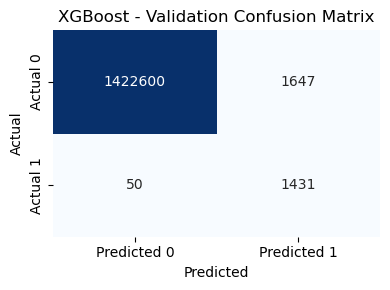


XGBoost Test Set:
              precision    recall  f1-score   support

           0      1.000     0.999     0.999   1424247
           1      0.458     0.967     0.621      1481

    accuracy                          0.999   1425728
   macro avg      0.729     0.983     0.810   1425728
weighted avg      0.999     0.999     0.999   1425728



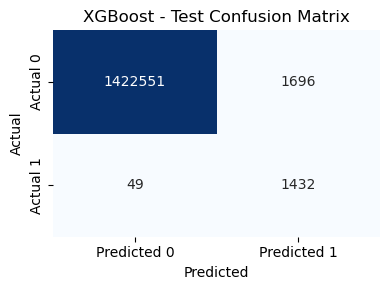

In [ ]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=(y_sample_train == 0).sum() / (y_sample_train == 1).sum(),
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_sample_train, y_sample_train)

xgb_val_probs = xgb_model.predict_proba(X_val)[:, 1]
thresholds = [0.1 * i for i in range(1, 10)]
xgb_best_f1 = 0
xgb_best_threshold = 0

print("=== XGBoost Threshold tuning (Validation Set) ===\n")
for threshold in thresholds:
    preds = (xgb_val_probs >= threshold).astype(int)
    precision = precision_score(y_val, preds, zero_division=0)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    print(f"Threshold={threshold:.1f} → Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    if f1 > xgb_best_f1:
        xgb_best_f1 = f1
        xgb_best_threshold = threshold

print(f"\nBest Threshold = {xgb_best_threshold:.2f} → F1 = {xgb_best_f1:.3f}")

xgb_val_preds = (xgb_val_probs >= xgb_best_threshold).astype(int)
xgb_val_cm = confusion_matrix(y_val, xgb_val_preds)
print("\nXGBoost Validation Set:")
print(classification_report(y_val, xgb_val_preds, digits=3))
plot_confusion_matrix(xgb_val_cm, title="XGBoost - Validation Confusion Matrix")

xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_test_preds = (xgb_test_probs >= xgb_best_threshold).astype(int)
xgb_test_cm = confusion_matrix(y_test, xgb_test_preds)
print("\nXGBoost Test Set:")
print(classification_report(y_test, xgb_test_preds, digits=3))
plot_confusion_matrix(xgb_test_cm, title="XGBoost - Test Confusion Matrix")

### Insights
#### • Excellent performance on the majority class (class 0) with nearly perfect precision and recall.
#### • Strong recall (96.7%) on the minority class (class 1), which is crucial for detecting true positives.
#### • Precision on class 1 is moderate (~46%), indicating some false positives — a common trade-off in imbalanced datasets.
#### • F1-score for class 1 is consistent between validation (0.628) and test (0.621), suggesting the model generalizes well.
#### • Overall accuracy is extremely high (99.9%) due to the class imbalance, so F1-score and confusion matrix are more reliable indicators.

-----

# Random Forest Model








=== Random Forest Threshold tuning (Validation Set) ===

Threshold=0.1 → Precision: 0.031, Recall: 1.000, F1: 0.059
Threshold=0.2 → Precision: 0.055, Recall: 1.000, F1: 0.104
Threshold=0.3 → Precision: 0.087, Recall: 0.999, F1: 0.161
Threshold=0.4 → Precision: 0.140, Recall: 0.993, F1: 0.245
Threshold=0.5 → Precision: 0.299, Recall: 0.978, F1: 0.458
Threshold=0.6 → Precision: 0.548, Recall: 0.963, F1: 0.698
Threshold=0.7 → Precision: 0.818, Recall: 0.940, F1: 0.875
Threshold=0.8 → Precision: 0.959, Recall: 0.907, F1: 0.932
Threshold=0.9 → Precision: 0.998, Recall: 0.831, F1: 0.907

Best Threshold = 0.80 → F1 = 0.932

Random Forest Validation Set:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000   1424247
           1      0.959     0.907     0.932      1481

    accuracy                          1.000   1425728
   macro avg      0.979     0.954     0.966   1425728
weighted avg      1.000     1.000     1.000   1425728



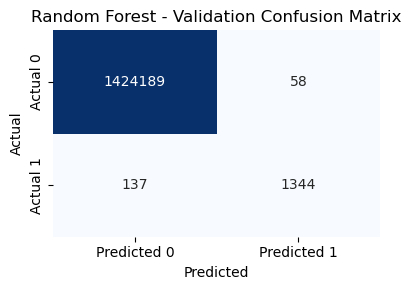


Random Forest Test Set:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000   1424247
           1      0.959     0.909     0.933      1481

    accuracy                          1.000   1425728
   macro avg      0.979     0.954     0.967   1425728
weighted avg      1.000     1.000     1.000   1425728



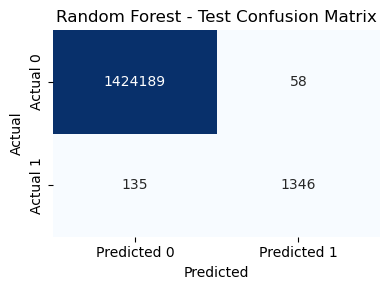

In [ ]:

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_sample_train, y_sample_train)

rf_val_probs = rf_model.predict_proba(X_val)[:, 1]
rf_best_f1 = 0
rf_best_threshold = 0

print("\n\n=== Random Forest Threshold tuning (Validation Set) ===\n")
for threshold in thresholds:
    preds = (rf_val_probs >= threshold).astype(int)
    precision = precision_score(y_val, preds, zero_division=0)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    print(f"Threshold={threshold:.1f} → Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    if f1 > rf_best_f1:
        rf_best_f1 = f1
        rf_best_threshold = threshold

print(f"\nBest Threshold = {rf_best_threshold:.2f} → F1 = {rf_best_f1:.3f}")

rf_val_preds = (rf_val_probs >= rf_best_threshold).astype(int)
rf_val_cm = confusion_matrix(y_val, rf_val_preds)
print("\nRandom Forest Validation Set:")
print(classification_report(y_val, rf_val_preds, digits=3))
plot_confusion_matrix(rf_val_cm, title="Random Forest - Validation Confusion Matrix")

rf_test_probs = rf_model.predict_proba(X_test)[:, 1]
rf_test_preds = (rf_test_probs >= rf_best_threshold).astype(int)
rf_test_cm = confusion_matrix(y_test, rf_test_preds)
print("\nRandom Forest Test Set:")
print(classification_report(y_test, rf_test_preds, digits=3))
plot_confusion_matrix(rf_test_cm, title="Random Forest - Test Confusion Matrix")


### Insights
#### • Very low false positives and false negatives on the minority class.
#### • Macro average F1-score: 0.967 (test), indicating balanced performance across classes.
#### • Weighted average F1-score: 1.000, reflecting dominance of majority class but still excellent handling of minority class.
#### • Validation and test set results are nearly identical → the model generalizes well.



----

#### Threshold Optimization: Precision, Recall, and F1-Score for Random Forest

The plot below illustrates how precision, recall, and F1-score evolve across different classification thresholds for the Random Forest model. By analyzing these curves, we can identify the optimal threshold that balances both precision and recall, ultimately maximizing the F1-score. This is especially useful for imbalanced classification problems where default thresholds (like 0.5) may not be ideal.


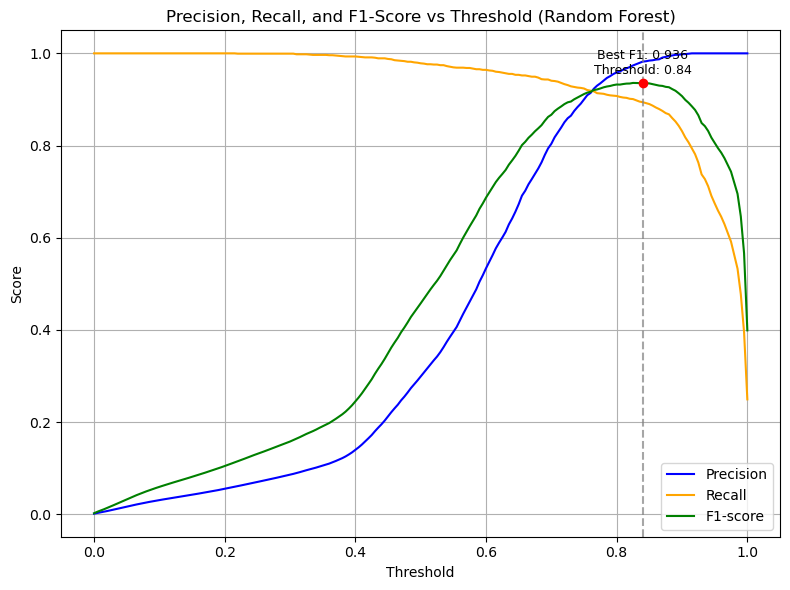

In [ ]:
# Get precision, recall, and thresholds for the validation set
precision, recall, thresholds = precision_recall_curve(y_val, rf_val_probs)

# Calculate F1-score for each threshold (exclude last precision/recall as thresholds is one shorter)
f1 = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Plot everything
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
plt.plot(thresholds, f1, label='F1-score', color='green')

# Highlight the best F1-score threshold
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
best_f1 = f1[best_idx]
plt.axvline(best_threshold, linestyle='--', color='gray', alpha=0.7)
plt.scatter(best_threshold, best_f1, color='red', zorder=5)
plt.text(best_threshold, best_f1 + 0.02, f"Best F1: {best_f1:.3f}\nThreshold: {best_threshold:.2f}",
         ha='center', fontsize=9)

# Labels and styling
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Threshold (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Interpretation

From the visualization, we observe that the F1-score reaches its peak at a threshold of **0.84**, achieving a score of approximately **0.936**. This point represents the most balanced trade-off between precision and recall for the Random Forest model.

Choosing this threshold means the model maintains a high precision—minimizing false positives—while still capturing a significant portion of true positives through strong recall. This supports the decision to tune thresholds rather than relying on defaults, and enhances the model’s real-world performance in identifying laundering transactions effectively.


----

#### Confusion Matrix Comparison: XGBoost vs Random Forest

The heatmaps below visualize the confusion matrices of the XGBoost and Random Forest classifiers on the test set. Each cell shows the absolute count of predictions categorized as **True Negatives (TN)**, **False Positives (FP)**, **False Negatives (FN)**, and **True Positives (TP)**. This direct side-by-side comparison highlights how each model performs across different types of classification outcomes.


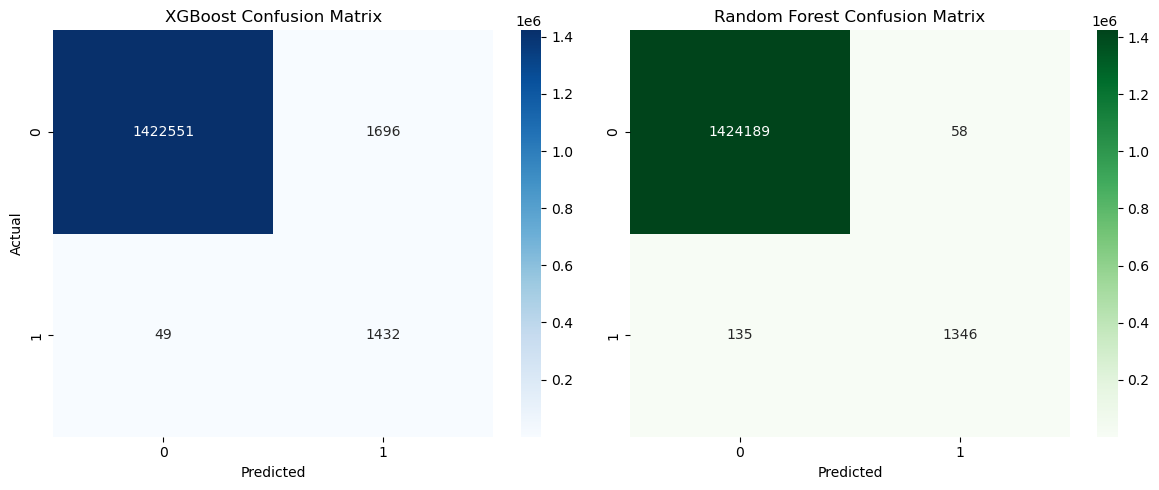

In [ ]:

# Create 2x2 confusion matrix heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
xgb_matrix = np.array([[xgb_tn, xgb_fp], [xgb_fn, xgb_tp]])
rf_matrix = np.array([[rf_tn, rf_fp], [rf_fn, rf_tp]])

sns.heatmap(xgb_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("XGBoost Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("Random Forest Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()


#### Interpretation

While both models demonstrate strong performance, Random Forest clearly outperforms XGBoost in minimizing **False Positives** and **False Negatives**. XGBoost, despite achieving high recall, incurs a higher number of false positives (1696) compared to Random Forest (58), which significantly impacts its precision.

Random Forest achieves better balance across all categories, especially with its low false positive count and higher true positive count. This confirms its superior generalization capability on unseen data, making it the most suitable model for real-world deployment in fraud detection scenarios.


----

#### Final Model Comparison: Precision, Recall, and F1-score

The bar chart below compares the final test set performance of all three classification models: **Logistic Regression**, **XGBoost**, and **Random Forest**. We evaluated the models using three key metrics — **Precision**, **Recall**, and **F1-score** — to ensure a balanced understanding of their classification quality, especially in the context of our imbalanced laundering dataset.


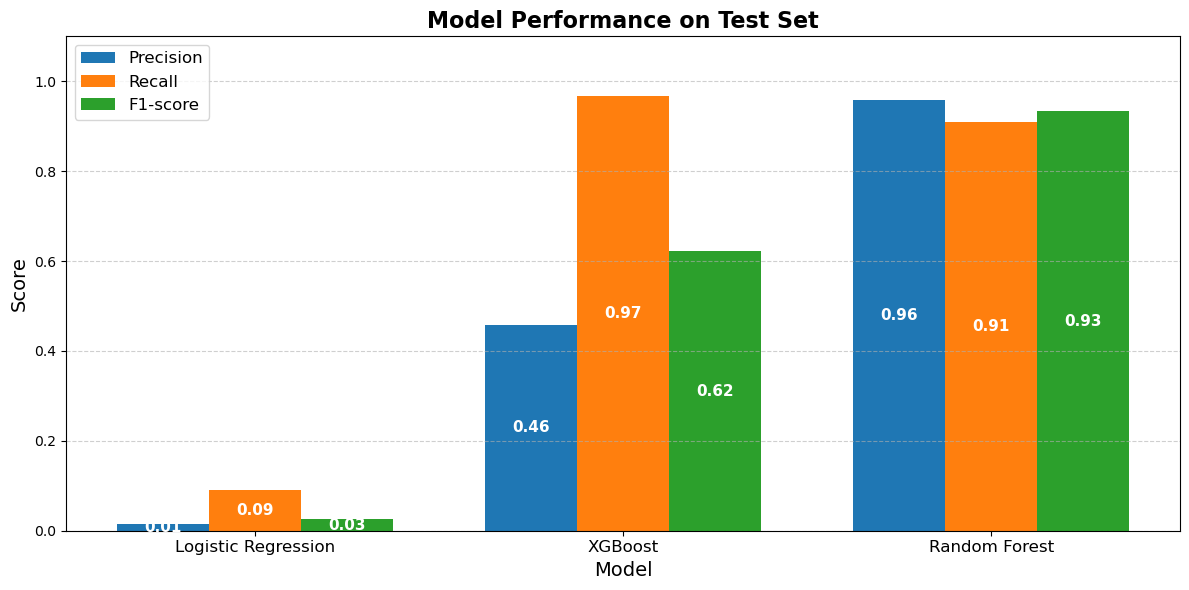

In [ ]:
# Compute final test metrics for all models
# Logistic Regression
lr_precision = precision_score(y_test, y_test_pred_best, zero_division=0)
lr_recall = recall_score(y_test, y_test_pred_best)
lr_f1 = f1_score(y_test, y_test_pred_best)

# XGBoost
xgb_precision = precision_score(y_test, xgb_test_preds, zero_division=0)
xgb_recall = recall_score(y_test, xgb_test_preds)
xgb_f1 = f1_score(y_test, xgb_test_preds)

# Random Forest
rf_precision = precision_score(y_test, rf_test_preds, zero_division=0)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1 = f1_score(y_test, rf_test_preds)

# Create bar chart
models = ['Logistic Regression', 'XGBoost', 'Random Forest']
precision = [lr_precision, xgb_precision, rf_precision]
recall = [lr_recall, xgb_recall, rf_recall]
f1 = [lr_f1, xgb_f1, rf_f1]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#1f77b4')
bars2 = ax.bar(x, recall, width, label='Recall', color='#ff7f0e')
bars3 = ax.bar(x + width, f1, width, label='F1-score', color='#2ca02c')

# Improve readability
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Model Performance on Test Set', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels inside bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                    ha='center', va='center',
                    fontsize=11, color='white', fontweight='bold')

plt.tight_layout()
plt.show()


#### Conclusion

The results clearly show that **Random Forest** outperforms both Logistic Regression and XGBoost across all evaluation metrics. Logistic Regression, while interpretable, fails to capture the complex, non-linear relationships in the data and shows very low performance. XGBoost performs well in terms of **recall**, indicating that it successfully identifies most laundering cases, but at the cost of a lower **precision**, leading to more false positives.

**Random Forest** provides the best overall balance, with high precision and recall, resulting in the highest **F1-score**. This model proves to be the most robust and reliable choice for detecting laundering patterns in our dataset.


-----

## Feature importance

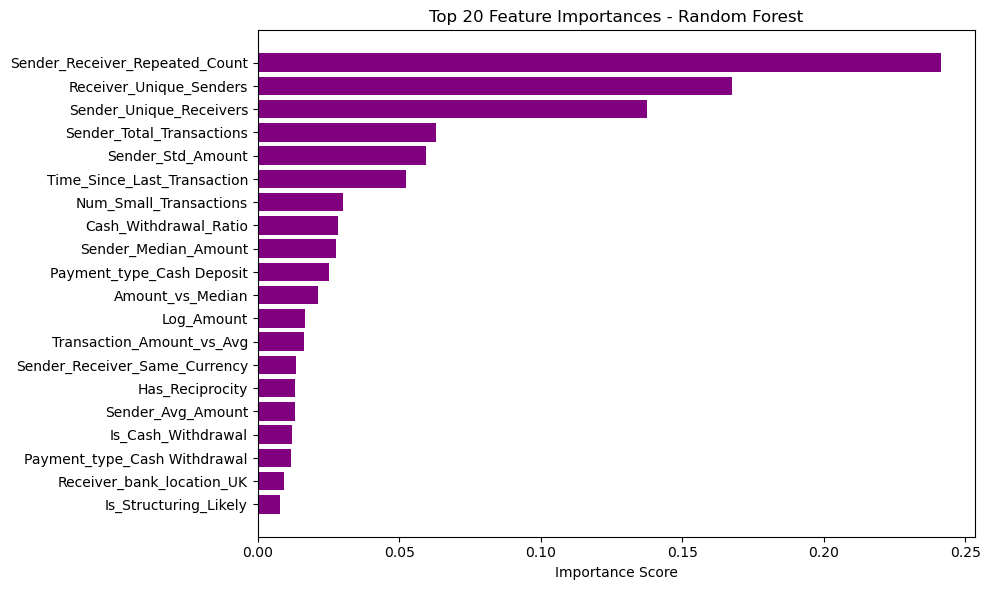

In [ ]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_

# Create a DataFrame for better handling
feature_names = X_sample_train.columns
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance (descending) and take top 20
top_feats = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_feats['feature'], top_feats['importance'], color='purple')
plt.gca().invert_yaxis()  # Highest at the top
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### Feature Importance Summary (Random Forest)
#### • Top features influencing the model:
####    - Sender_Receiver_Repeated_Count
####    - Receiver_Unique_Senders
####    - Sender_Unique_Receivers

#### • These features likely capture transactional patterns between entities.
#### • High-scoring features may indicate behavioral signals of fraud or anomaly.
#### • Long tail of features contributes less but may still add marginal gains.


----
## SHAP analysis: Feature impact on Llaundering detection


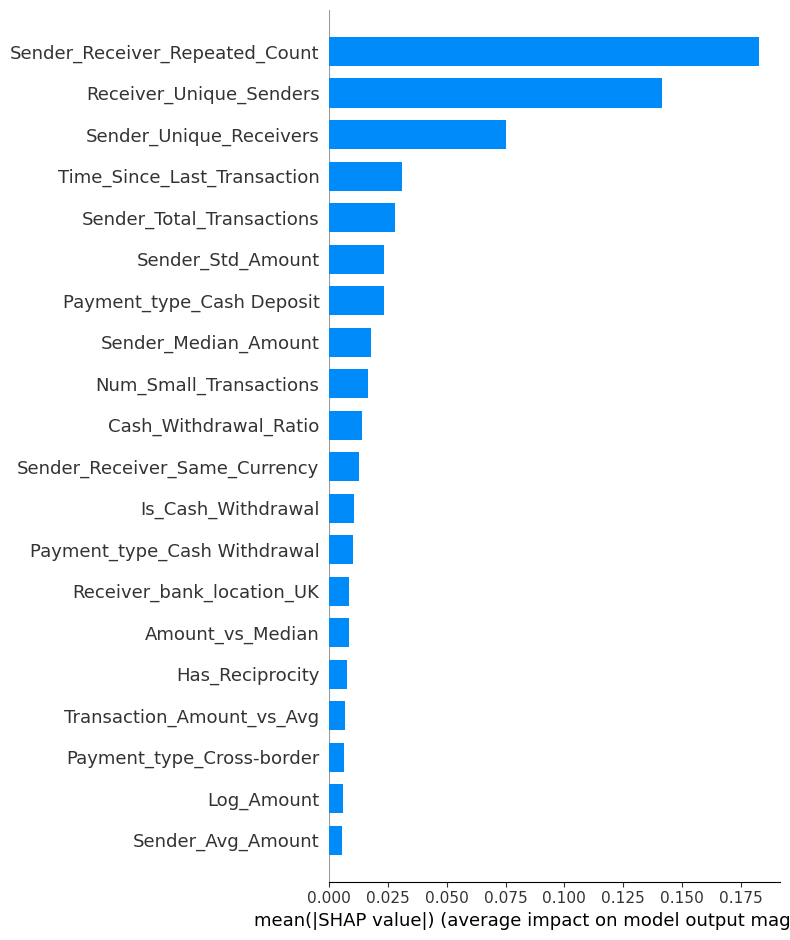

In [ ]:

#  Sample a small, balanced subset from validation set ---
X_val_copy = X_val.copy()
X_val_copy['Is_laundering'] = y_val

# Get all positive (class 1) examples
laundering_val = X_val_copy[X_val_copy['Is_laundering'] == 1]

# Sample negatives (class 0) to balance it
non_laundering_val = X_val_copy[X_val_copy['Is_laundering'] == 0].sample(n=500, random_state=42)

# Combine and separate X and y again
sample_val_df = pd.concat([laundering_val, non_laundering_val], ignore_index=True)
y_explain = sample_val_df['Is_laundering']
X_explain = sample_val_df.drop(columns=['Is_laundering'])

# Run SHAP on the Random Forest model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_explain)

# Plot feature importance summary for class 1
shap.summary_plot(shap_values[1], X_explain, plot_type="bar")


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


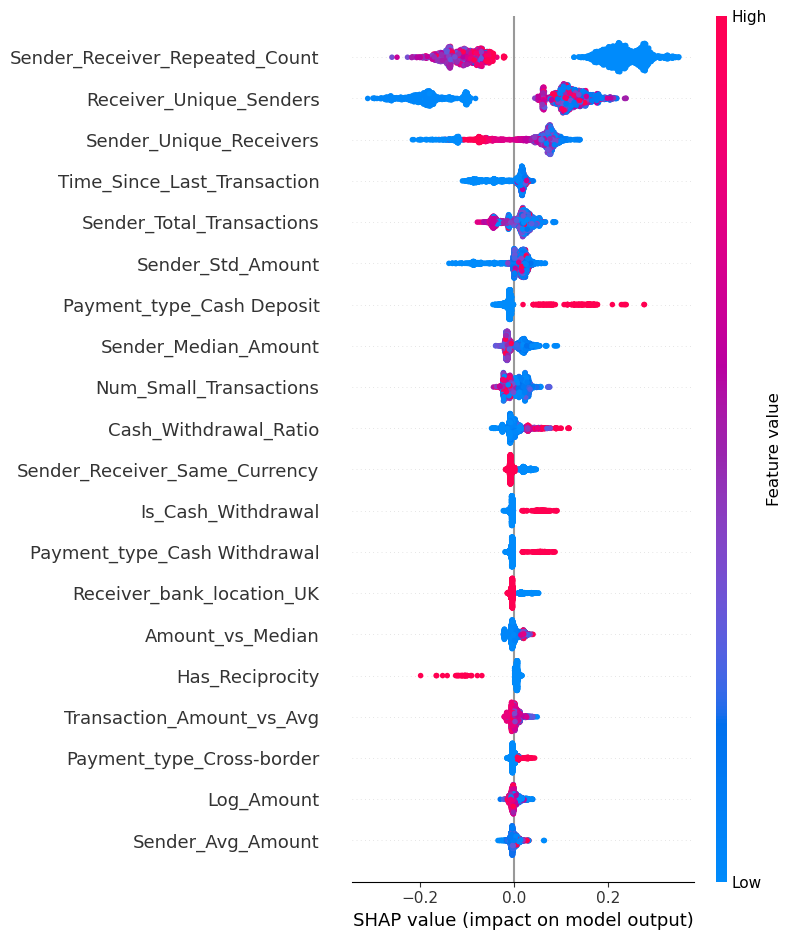

In [ ]:
shap.summary_plot(shap_values[1], X_explain)


#### SHAP interpretation summary for Random Forest Model

#### • Repeated transactions between the same sender and receiver are a major red flag.
The model sees this as a strong signal of suspicious behavior.

#### • Accounts dealing with only a few unique senders or receivers are more likely to be flagged.  
This suggests that tight, closed transaction networks raise laundering risk.

#### • Other factors like transaction frequency, timing, and cash activity also contribute.  
While not as dominant, they still help the model make its decisions.

#### • SHAP doesn't just tell us which features matter — it shows **how** they push predictions.  
High values of some features increase the chance of being labeled as laundering, while low values reduce it.

---

#### Overall
The model is focusing on behavioral patterns, not just transaction amounts.  
Thanks to SHAP, we can clearly see that it’s learning meaningful indicators — not just guessing blindly.
